# Homework 11 - Transfer Learning (Domain Adversarial Training)

> Author: Howard Wang (b08902047@ntu.edu.tw)

If there are any questions, please contact mlta-2023-spring@googlegroups.com

# Readme

In homework 11, you will need to implement Domain Adversarial Training in Transfer Learning. As shown in the bottom left part of the figure.

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

>

## Scenario and Why Domain Adversarial Training
Now we have labeled source data and unlabeled target data, where source data might be relavent to the target data. We now want to train a model with source data only and test it on target data.

What problem might occur if we do so? After we have learned Anomaly Detection, we now know that if we test the model with an abnormal data that have never appeared in source data, our trained model is likely to result in poor performance since it is not familiar with the abnormal data.

For example, we have a model that contains Feature Extractor and Classifier:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

When the model is trained with source data, the feature extractor
will extract meaningful features since it is familiar with the distribution of it.It could be seen in the following figure that the blue dots, which is the distribution of source data, has already been clustered into different clusters. Therefore, the Classifier can predict the label based on these clusters.

However, when test on the target data, the Feature Extractor will not be able to extract meaningful features that follow the distribution of the source feature distribution, which result in the classifier learned for the source domain will not be able to apply to the target domain.


## Domain Adversarial Training of Nerural Networks (DaNN)

Based on the above problems, DaNN approaches build mappings between the source (training-time) and the target (test-time) domains, so that the classifier learned for the source domain can also be applied to the target domain, when composed with the learned mapping between domains.

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

In DaNN, the authors added a Domain Classifier, which is a deep discriminatively-trained classifeir in the training framework to distinguish the data from different domain by the features extracted by the feature extractor. As the training progresses, the approach promotes a domain classifier that discriminates between the source and the target domains and a feature extractor that can extractor features that are discriminative for the main learning task on the source domain and indiscriminate with respect to the shift between the domains.


The feature extractor are likely to outperform the domain classifier as its input are generated by the feature extractor and that the task of domain classification and label classification are not conflict.

This method leads to the emergence of features that are domain-invariant and on the same feature distribution.

# Data Introduce

Our task contains source data: real photos, and target data: hand-drawn graffiti.

We are going to train the model with the photos and the labels, and try to predict what the labels are for hand-drawn graffiti.

The data could be downloaded [here](https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.0/real_or_drawing.zip). The code below is for data downloading and visualization.

Note that: **The source and target data are all balanced data, you can make use of this information.**

In [1]:
# Download dataset
!wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.0/real_or_drawing.zip" -O real_or_drawing.zip

# Download from mirrored dataset link
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.1/real_or_drawing.zip" -O real_or_drawing.zip
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.2/real_or_drawing.zip" -O real_or_drawing.zip

# Unzip the files
!unzip real_or_drawing.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_or_drawing/train_data/0/106.bmp  
  inflating: real_or_drawing/train_data/0/107.bmp  
  inflating: real_or_drawing/train_data/0/108.bmp  
  inflating: real_or_drawing/train_data/0/109.bmp  
  inflating: real_or_drawing/train_data/0/11.bmp  
  inflating: real_or_drawing/train_data/0/110.bmp  
  inflating: real_or_drawing/train_data/0/111.bmp  
  inflating: real_or_drawing/train_data/0/112.bmp  
  inflating: real_or_drawing/train_data/0/113.bmp  
  inflating: real_or_drawing/train_data/0/114.bmp  
  inflating: real_or_drawing/train_data/0/115.bmp  
  inflating: real_or_drawing/train_data/0/116.bmp  
  inflating: real_or_drawing/train_data/0/117.bmp  
  inflating: real_or_drawing/train_data/0/118.bmp  
  inflating: real_or_drawing/train_data/0/119.bmp  
  inflating: real_or_drawing/train_data/0/12.bmp  
  inflating: real_or_drawing/train_data/0/120.bmp  
  inflating: real_or_drawing/train_data/0/121.bmp  
  inflating: re

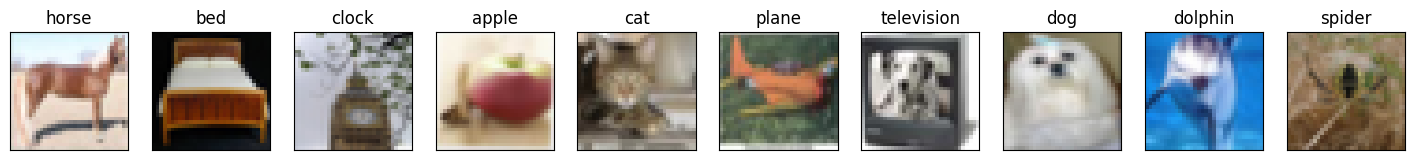

In [2]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

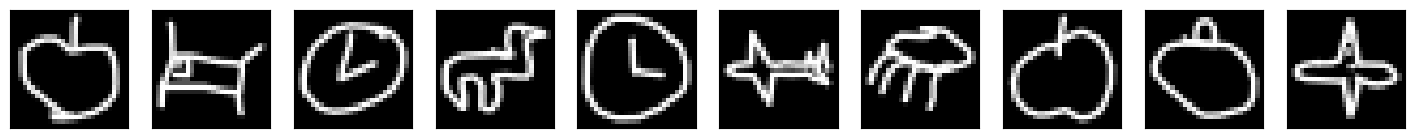

In [3]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

# Special Domain Knowledge

When we graffiti, we usually draw the outline only, therefore we can perform edge detection processing on the source data to make it more similar to the target data.


## Canny Edge Detection
The implementation of Canny Edge Detection is as follow.
The algorithm will not be describe thoroughly here.  If you are interested, please refer to the wiki or [here](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19).

We only need two parameters to implement Canny Edge Detection with CV2:  `low_threshold` and `high_threshold`.

```cv2.Canny(image, low_threshold, high_threshold)```

Simply put, when the edge value exceeds the high_threshold, we determine it as an edge. If the edge value is only above low_threshold, we will then determine whether it is an edge or not.

Let's implement it on the source data.

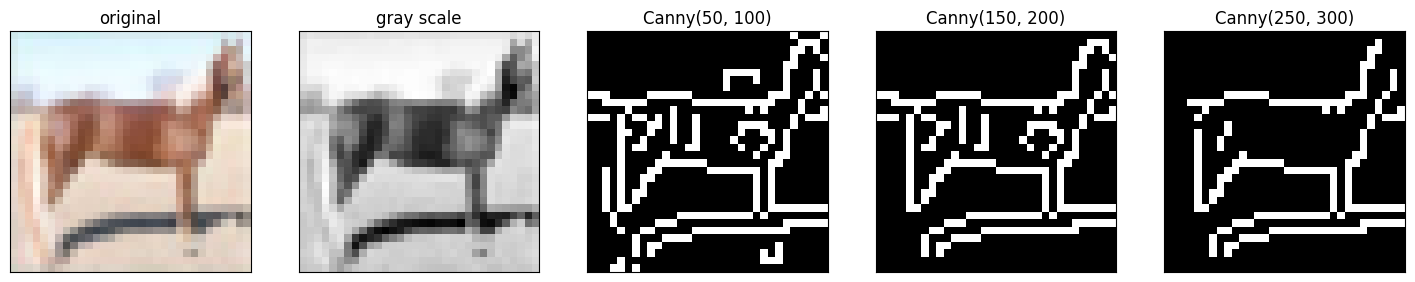

In [4]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')


# Data Process


The data is suitible for `torchvision.ImageFolder`. You can create a dataset with `torchvision.ImageFolder`. Details for image augmentation please refer to the comments in the following codes.

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


from rich.progress import Progress, TextColumn, BarColumn, TimeElapsedColumn, TimeRemainingColumn, track
import time


source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array,
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])

source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)

source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)

# Model

Feature Extractor: Classic VGG-like architecture

Label Predictor / Domain Classifier: Linear models.

In [6]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

# Pre-processing

Here we use Adam as our optimizor.

In [7]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

# Start Training


## DaNN Implementation

In the original paper, Gradient Reversal Layer is used.
Feature Extractor, Label Predictor, and Domain Classifier are all trained at the same time. In this code, we train Domain Classifier first, and then train our Feature Extractor (same concept as Generator and Discriminator training process in GAN).

## Reminder
* Lambda, which controls the domain adversarial loss, is adaptive in the original paper. You can refer to [the original work](https://arxiv.org/pdf/1505.07818.pdf) . Here lambda is set to 0.1.
* We do not have the label to target data, you can only evaluate your model by uploading your result to kaggle.:)

In [8]:
def train_epoch(source_dataloader, target_dataloader, progress, lamb):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0
    batch_tqdm = progress.add_task(description=f"batch_progress", total=len(source_dataloader))

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()

        # Mixed the source data and target data, or it'll mislead the running params
        #   of batch_norm. (runnning mean/var of soucre and target data are different.)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        # set domain label of source data to be 1.
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : train domain classifier
        feature = feature_extractor(mixed_data)
        # We don't need to train feature extractor in step 1.
        # Thus we detach the feature neuron to avoid backpropgation.
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss+= loss.item()
        loss.backward()
        optimizer_D.step()

        # Step 2 : train feature extractor and label classifier
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        # loss = cross entropy of classification - lamb * domain binary cross entropy.
        #  The reason why using subtraction is similar to generator loss in disciminator of GAN
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        progress.advance(batch_tqdm, advance=1)

    progress.remove_task(batch_tqdm)
    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num

num_epochs = 1000
# train 200 epochs
lamb = 0.02

with Progress(TextColumn("[progress.description]{task.description}"),
              BarColumn(),
              TextColumn("[progress.percentage]{task.percentage:>3.0f}%"),
              TimeRemainingColumn(),
              TimeElapsedColumn()) as progress:
    epoch_tqdm = progress.add_task(description="epoch progress", total=num_epochs)
    for epoch in range(num_epochs):
        lamb = np.log(1.02 + 1.7 * epoch / num_epochs)
        train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader, progress, lamb)

        progress.advance(epoch_tqdm, advance=1)
        if epoch == 10:
          torch.save(feature_extractor.state_dict(), f'extractor_model_early.bin')
          torch.save(label_predictor.state_dict(), f'predictor_model_early.bin')
        elif epoch == 100:
          torch.save(feature_extractor.state_dict(), f'extractor_model_mid.bin')
          torch.save(label_predictor.state_dict(), f'predictor_model_mid.bin')

        torch.save(feature_extractor.state_dict(), f'extractor_model.bin')
        torch.save(label_predictor.state_dict(), f'predictor_model.bin')
        print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc))




Output()

epoch   0: train D loss: 0.4094, train F loss: 1.8614, acc 0.3216

epoch   1: train D loss: 0.4866, train F loss: 1.5713, acc 0.4322

epoch   2: train D loss: 0.4263, train F loss: 1.4541, acc 0.4804

epoch   3: train D loss: 0.3883, train F loss: 1.3907, acc 0.5068

epoch   4: train D loss: 0.4035, train F loss: 1.3586, acc 0.5174

epoch   5: train D loss: 0.3715, train F loss: 1.2801, acc 0.5528

epoch   6: train D loss: 0.3855, train F loss: 1.2303, acc 0.5636

epoch   7: train D loss: 0.3673, train F loss: 1.1953, acc 0.5844

epoch   8: train D loss: 0.3656, train F loss: 1.1485, acc 0.5950

epoch   9: train D loss: 0.3609, train F loss: 1.1280, acc 0.6060

epoch  10: train D loss: 0.3749, train F loss: 1.0693, acc 0.6228

epoch  11: train D loss: 0.3662, train F loss: 1.0509, acc 0.6266

epoch  12: train D loss: 0.3671, train F loss: 1.0267, acc 0.6342

epoch  13: train D loss: 0.3705, train F loss: 0.9821, acc 0.6494

epoch  14: train D loss: 0.3697, train F loss: 0.9511, acc 0.6668

epoch  15: train D loss: 0.3610, train F loss: 0.9117, acc 0.6738

epoch  16: train D loss: 0.3734, train F loss: 0.8833, acc 0.6918

epoch  17: train D loss: 0.3571, train F loss: 0.8451, acc 0.7020

epoch  18: train D loss: 0.3573, train F loss: 0.8336, acc 0.7024

epoch  19: train D loss: 0.3549, train F loss: 0.7592, acc 0.7312

epoch  20: train D loss: 0.3363, train F loss: 0.7544, acc 0.7376

epoch  21: train D loss: 0.3474, train F loss: 0.7222, acc 0.7542

epoch  22: train D loss: 0.3251, train F loss: 0.6808, acc 0.7608

epoch  23: train D loss: 0.3253, train F loss: 0.6674, acc 0.7714

epoch  24: train D loss: 0.3339, train F loss: 0.6394, acc 0.7686

epoch  25: train D loss: 0.3367, train F loss: 0.5884, acc 0.7930

epoch  26: train D loss: 0.3258, train F loss: 0.5443, acc 0.8038

epoch  27: train D loss: 0.3246, train F loss: 0.5240, acc 0.8120

epoch  28: train D loss: 0.3278, train F loss: 0.4919, acc 0.8236

epoch  29: train D loss: 0.3289, train F loss: 0.4970, acc 0.8190

epoch  30: train D loss: 0.3293, train F loss: 0.4490, acc 0.8408

epoch  31: train D loss: 0.3069, train F loss: 0.4334, acc 0.8436

epoch  32: train D loss: 0.3137, train F loss: 0.4195, acc 0.8528

epoch  33: train D loss: 0.3236, train F loss: 0.3815, acc 0.8662

epoch  34: train D loss: 0.3060, train F loss: 0.3592, acc 0.8640

epoch  35: train D loss: 0.3094, train F loss: 0.3410, acc 0.8756

epoch  36: train D loss: 0.3123, train F loss: 0.3403, acc 0.8752

epoch  37: train D loss: 0.3055, train F loss: 0.3264, acc 0.8806

epoch  38: train D loss: 0.3167, train F loss: 0.3000, acc 0.8942

epoch  39: train D loss: 0.3111, train F loss: 0.3049, acc 0.8882

epoch  40: train D loss: 0.3124, train F loss: 0.2734, acc 0.8970

epoch  41: train D loss: 0.3164, train F loss: 0.2808, acc 0.8966

epoch  42: train D loss: 0.3184, train F loss: 0.2313, acc 0.9118

epoch  43: train D loss: 0.3226, train F loss: 0.2216, acc 0.9170

epoch  44: train D loss: 0.3155, train F loss: 0.2372, acc 0.9084

epoch  45: train D loss: 0.3172, train F loss: 0.2074, acc 0.9202

epoch  46: train D loss: 0.3187, train F loss: 0.2290, acc 0.9130

epoch  47: train D loss: 0.3020, train F loss: 0.2244, acc 0.9194

epoch  48: train D loss: 0.3215, train F loss: 0.1945, acc 0.9260

epoch  49: train D loss: 0.3320, train F loss: 0.1831, acc 0.9244

epoch  50: train D loss: 0.3336, train F loss: 0.1840, acc 0.9270

epoch  51: train D loss: 0.3205, train F loss: 0.1847, acc 0.9264

epoch  52: train D loss: 0.3284, train F loss: 0.1694, acc 0.9302

epoch  53: train D loss: 0.3345, train F loss: 0.1645, acc 0.9356

epoch  54: train D loss: 0.3163, train F loss: 0.1574, acc 0.9354

epoch  55: train D loss: 0.3228, train F loss: 0.1523, acc 0.9352

epoch  56: train D loss: 0.3323, train F loss: 0.1566, acc 0.9402

epoch  57: train D loss: 0.3347, train F loss: 0.1403, acc 0.9436

epoch  58: train D loss: 0.3367, train F loss: 0.1329, acc 0.9418

epoch  59: train D loss: 0.3335, train F loss: 0.1403, acc 0.9412

epoch  60: train D loss: 0.3371, train F loss: 0.1458, acc 0.9400

epoch  61: train D loss: 0.3455, train F loss: 0.1171, acc 0.9484

epoch  62: train D loss: 0.3617, train F loss: 0.1465, acc 0.9402

epoch  63: train D loss: 0.3448, train F loss: 0.0998, acc 0.9540

epoch  64: train D loss: 0.3481, train F loss: 0.1232, acc 0.9448

epoch  65: train D loss: 0.3745, train F loss: 0.1111, acc 0.9504

epoch  66: train D loss: 0.3719, train F loss: 0.0904, acc 0.9538

epoch  67: train D loss: 0.3726, train F loss: 0.1186, acc 0.9454

epoch  68: train D loss: 0.3614, train F loss: 0.1076, acc 0.9524

epoch  69: train D loss: 0.3691, train F loss: 0.0904, acc 0.9548

epoch  70: train D loss: 0.3790, train F loss: 0.1018, acc 0.9492

epoch  71: train D loss: 0.3779, train F loss: 0.0853, acc 0.9578

epoch  72: train D loss: 0.3889, train F loss: 0.0790, acc 0.9578

epoch  73: train D loss: 0.3866, train F loss: 0.0854, acc 0.9542

epoch  74: train D loss: 0.3947, train F loss: 0.0766, acc 0.9580

epoch  75: train D loss: 0.3999, train F loss: 0.0910, acc 0.9542

epoch  76: train D loss: 0.3890, train F loss: 0.0837, acc 0.9564

epoch  77: train D loss: 0.3793, train F loss: 0.0849, acc 0.9538

epoch  78: train D loss: 0.3917, train F loss: 0.0774, acc 0.9574

epoch  79: train D loss: 0.4025, train F loss: 0.0762, acc 0.9556

epoch  80: train D loss: 0.4037, train F loss: 0.0622, acc 0.9602

epoch  81: train D loss: 0.4173, train F loss: 0.0576, acc 0.9602

epoch  82: train D loss: 0.4117, train F loss: 0.0654, acc 0.9570

epoch  83: train D loss: 0.3984, train F loss: 0.0557, acc 0.9632

epoch  84: train D loss: 0.4133, train F loss: 0.0592, acc 0.9598

epoch  85: train D loss: 0.4129, train F loss: 0.0525, acc 0.9620

epoch  86: train D loss: 0.4203, train F loss: 0.0368, acc 0.9646

epoch  87: train D loss: 0.4177, train F loss: 0.0346, acc 0.9676

epoch  88: train D loss: 0.4300, train F loss: 0.0620, acc 0.9616

epoch  89: train D loss: 0.4262, train F loss: 0.0503, acc 0.9624

epoch  90: train D loss: 0.4426, train F loss: 0.0434, acc 0.9626

epoch  91: train D loss: 0.4435, train F loss: 0.0297, acc 0.9652

epoch  92: train D loss: 0.4340, train F loss: 0.0423, acc 0.9640

epoch  93: train D loss: 0.4410, train F loss: 0.0429, acc 0.9636

epoch  94: train D loss: 0.4232, train F loss: 0.0459, acc 0.9616

epoch  95: train D loss: 0.4468, train F loss: 0.0346, acc 0.9652

epoch  96: train D loss: 0.4327, train F loss: 0.0240, acc 0.9690

epoch  97: train D loss: 0.4295, train F loss: 0.0342, acc 0.9674

epoch  98: train D loss: 0.4581, train F loss: 0.0300, acc 0.9648

epoch  99: train D loss: 0.4350, train F loss: 0.0385, acc 0.9636

epoch 100: train D loss: 0.4461, train F loss: 0.0216, acc 0.9700

epoch 101: train D loss: 0.4552, train F loss: 0.0285, acc 0.9644

epoch 102: train D loss: 0.4694, train F loss: 0.0099, acc 0.9716

epoch 103: train D loss: 0.4513, train F loss: 0.0139, acc 0.9720

epoch 104: train D loss: 0.4523, train F loss: 0.0167, acc 0.9686

epoch 105: train D loss: 0.4458, train F loss: 0.0343, acc 0.9646

epoch 106: train D loss: 0.4433, train F loss: 0.0462, acc 0.9624

epoch 107: train D loss: 0.4571, train F loss: 0.0304, acc 0.9664

epoch 108: train D loss: 0.4570, train F loss: 0.0057, acc 0.9724

epoch 109: train D loss: 0.4678, train F loss: 0.0212, acc 0.9666

epoch 110: train D loss: 0.4808, train F loss: 0.0041, acc 0.9708

epoch 111: train D loss: 0.4435, train F loss: -0.0003, acc 0.9742

epoch 112: train D loss: 0.4646, train F loss: 0.0082, acc 0.9682

epoch 113: train D loss: 0.4647, train F loss: 0.0043, acc 0.9714

epoch 114: train D loss: 0.4738, train F loss: 0.0106, acc 0.9706

epoch 115: train D loss: 0.4798, train F loss: 0.0105, acc 0.9676

epoch 116: train D loss: 0.4840, train F loss: 0.0096, acc 0.9644

epoch 117: train D loss: 0.4778, train F loss: 0.0000, acc 0.9688

epoch 118: train D loss: 0.4750, train F loss: -0.0015, acc 0.9692

epoch 119: train D loss: 0.4595, train F loss: 0.0024, acc 0.9696

epoch 120: train D loss: 0.4773, train F loss: -0.0063, acc 0.9700

epoch 121: train D loss: 0.4863, train F loss: -0.0088, acc 0.9710

epoch 122: train D loss: 0.4774, train F loss: -0.0112, acc 0.9746

epoch 123: train D loss: 0.4874, train F loss: 0.0084, acc 0.9662

epoch 124: train D loss: 0.4766, train F loss: 0.0002, acc 0.9698

epoch 125: train D loss: 0.4823, train F loss: -0.0112, acc 0.9728

epoch 126: train D loss: 0.4809, train F loss: -0.0174, acc 0.9770

epoch 127: train D loss: 0.4842, train F loss: -0.0141, acc 0.9726

epoch 128: train D loss: 0.4943, train F loss: -0.0076, acc 0.9706

epoch 129: train D loss: 0.4928, train F loss: -0.0252, acc 0.9758

epoch 130: train D loss: 0.4902, train F loss: 0.0086, acc 0.9684

epoch 131: train D loss: 0.4783, train F loss: -0.0284, acc 0.9772

epoch 132: train D loss: 0.4946, train F loss: -0.0107, acc 0.9696

epoch 133: train D loss: 0.4832, train F loss: -0.0212, acc 0.9718

epoch 134: train D loss: 0.5136, train F loss: -0.0194, acc 0.9728

epoch 135: train D loss: 0.4760, train F loss: -0.0056, acc 0.9706

epoch 136: train D loss: 0.5023, train F loss: -0.0312, acc 0.9730

epoch 137: train D loss: 0.4989, train F loss: -0.0386, acc 0.9788

epoch 138: train D loss: 0.5216, train F loss: -0.0420, acc 0.9752

epoch 139: train D loss: 0.5090, train F loss: -0.0179, acc 0.9710

epoch 140: train D loss: 0.4946, train F loss: -0.0379, acc 0.9760

epoch 141: train D loss: 0.5075, train F loss: -0.0375, acc 0.9762

epoch 142: train D loss: 0.5072, train F loss: -0.0393, acc 0.9764

epoch 143: train D loss: 0.5029, train F loss: -0.0383, acc 0.9766

epoch 144: train D loss: 0.4989, train F loss: -0.0200, acc 0.9718

epoch 145: train D loss: 0.5061, train F loss: -0.0380, acc 0.9746

epoch 146: train D loss: 0.5133, train F loss: -0.0452, acc 0.9786

epoch 147: train D loss: 0.5248, train F loss: -0.0422, acc 0.9742

epoch 148: train D loss: 0.5078, train F loss: -0.0247, acc 0.9702

epoch 149: train D loss: 0.5172, train F loss: -0.0520, acc 0.9776

epoch 150: train D loss: 0.5249, train F loss: -0.0495, acc 0.9788

epoch 151: train D loss: 0.5210, train F loss: -0.0382, acc 0.9738

epoch 152: train D loss: 0.5143, train F loss: -0.0414, acc 0.9772

epoch 153: train D loss: 0.5043, train F loss: -0.0528, acc 0.9796

epoch 154: train D loss: 0.5227, train F loss: -0.0627, acc 0.9778

epoch 155: train D loss: 0.5262, train F loss: -0.0503, acc 0.9744

epoch 156: train D loss: 0.5283, train F loss: -0.0407, acc 0.9704

epoch 157: train D loss: 0.5213, train F loss: -0.0557, acc 0.9784

epoch 158: train D loss: 0.5244, train F loss: -0.0485, acc 0.9748

epoch 159: train D loss: 0.5326, train F loss: -0.0488, acc 0.9720

epoch 160: train D loss: 0.5202, train F loss: -0.0478, acc 0.9748

epoch 161: train D loss: 0.5299, train F loss: -0.0455, acc 0.9704

epoch 162: train D loss: 0.5181, train F loss: -0.0644, acc 0.9796

epoch 163: train D loss: 0.5220, train F loss: -0.0531, acc 0.9758

epoch 164: train D loss: 0.5230, train F loss: -0.0763, acc 0.9808

epoch 165: train D loss: 0.5308, train F loss: -0.0540, acc 0.9718

epoch 166: train D loss: 0.5374, train F loss: -0.0630, acc 0.9756

epoch 167: train D loss: 0.5281, train F loss: -0.0565, acc 0.9758

epoch 168: train D loss: 0.5269, train F loss: -0.0575, acc 0.9760

epoch 169: train D loss: 0.5329, train F loss: -0.0663, acc 0.9762

epoch 170: train D loss: 0.5351, train F loss: -0.0694, acc 0.9782

epoch 171: train D loss: 0.5250, train F loss: -0.0677, acc 0.9766

epoch 172: train D loss: 0.5470, train F loss: -0.0566, acc 0.9708

epoch 173: train D loss: 0.5297, train F loss: -0.0692, acc 0.9776

epoch 174: train D loss: 0.5232, train F loss: -0.0594, acc 0.9756

epoch 175: train D loss: 0.5343, train F loss: -0.0708, acc 0.9790

epoch 176: train D loss: 0.5337, train F loss: -0.0719, acc 0.9792

epoch 177: train D loss: 0.5387, train F loss: -0.0701, acc 0.9752

epoch 178: train D loss: 0.5471, train F loss: -0.0847, acc 0.9764

epoch 179: train D loss: 0.5381, train F loss: -0.0872, acc 0.9808

epoch 180: train D loss: 0.5502, train F loss: -0.0807, acc 0.9760

epoch 181: train D loss: 0.5459, train F loss: -0.0877, acc 0.9790

epoch 182: train D loss: 0.5488, train F loss: -0.0842, acc 0.9778

epoch 183: train D loss: 0.5453, train F loss: -0.0832, acc 0.9786

epoch 184: train D loss: 0.5511, train F loss: -0.0783, acc 0.9754

epoch 185: train D loss: 0.5402, train F loss: -0.0801, acc 0.9772

epoch 186: train D loss: 0.5514, train F loss: -0.0847, acc 0.9762

epoch 187: train D loss: 0.5507, train F loss: -0.0963, acc 0.9802

epoch 188: train D loss: 0.5488, train F loss: -0.0840, acc 0.9766

epoch 189: train D loss: 0.5474, train F loss: -0.0930, acc 0.9802

epoch 190: train D loss: 0.5608, train F loss: -0.0911, acc 0.9786

epoch 191: train D loss: 0.5512, train F loss: -0.0734, acc 0.9716

epoch 192: train D loss: 0.5444, train F loss: -0.0981, acc 0.9816

epoch 193: train D loss: 0.5542, train F loss: -0.0868, acc 0.9776

epoch 194: train D loss: 0.5524, train F loss: -0.1027, acc 0.9832

epoch 195: train D loss: 0.5555, train F loss: -0.0956, acc 0.9788

epoch 196: train D loss: 0.5571, train F loss: -0.0982, acc 0.9782

epoch 197: train D loss: 0.5483, train F loss: -0.1009, acc 0.9824

epoch 198: train D loss: 0.5564, train F loss: -0.0908, acc 0.9810

epoch 199: train D loss: 0.5459, train F loss: -0.1024, acc 0.9810

epoch 200: train D loss: 0.5534, train F loss: -0.1083, acc 0.9826

epoch 201: train D loss: 0.5623, train F loss: -0.0949, acc 0.9752

epoch 202: train D loss: 0.5572, train F loss: -0.1027, acc 0.9828

epoch 203: train D loss: 0.5620, train F loss: -0.0923, acc 0.9768

epoch 204: train D loss: 0.5604, train F loss: -0.1043, acc 0.9792

epoch 205: train D loss: 0.5555, train F loss: -0.0982, acc 0.9788

epoch 206: train D loss: 0.5629, train F loss: -0.1115, acc 0.9814

epoch 207: train D loss: 0.5657, train F loss: -0.1157, acc 0.9816

epoch 208: train D loss: 0.5644, train F loss: -0.0924, acc 0.9772

epoch 209: train D loss: 0.5598, train F loss: -0.1094, acc 0.9800

epoch 210: train D loss: 0.5559, train F loss: -0.1141, acc 0.9824

epoch 211: train D loss: 0.5653, train F loss: -0.0828, acc 0.9740

epoch 212: train D loss: 0.5684, train F loss: -0.1097, acc 0.9770

epoch 213: train D loss: 0.5608, train F loss: -0.1201, acc 0.9794

epoch 214: train D loss: 0.5616, train F loss: -0.1155, acc 0.9798

epoch 215: train D loss: 0.5564, train F loss: -0.1155, acc 0.9812

epoch 216: train D loss: 0.5585, train F loss: -0.1043, acc 0.9778

epoch 217: train D loss: 0.5634, train F loss: -0.1304, acc 0.9844

epoch 218: train D loss: 0.5649, train F loss: -0.1230, acc 0.9808

epoch 219: train D loss: 0.5650, train F loss: -0.1163, acc 0.9806

epoch 220: train D loss: 0.5678, train F loss: -0.1214, acc 0.9806

epoch 221: train D loss: 0.5747, train F loss: -0.1161, acc 0.9784

epoch 222: train D loss: 0.5719, train F loss: -0.1187, acc 0.9796

epoch 223: train D loss: 0.5554, train F loss: -0.1119, acc 0.9774

epoch 224: train D loss: 0.5680, train F loss: -0.1252, acc 0.9810

epoch 225: train D loss: 0.5670, train F loss: -0.1256, acc 0.9790

epoch 226: train D loss: 0.5597, train F loss: -0.1276, acc 0.9830

epoch 227: train D loss: 0.5645, train F loss: -0.1232, acc 0.9806

epoch 228: train D loss: 0.5583, train F loss: -0.1130, acc 0.9794

epoch 229: train D loss: 0.5817, train F loss: -0.1242, acc 0.9774

epoch 230: train D loss: 0.5706, train F loss: -0.1226, acc 0.9792

epoch 231: train D loss: 0.5726, train F loss: -0.1381, acc 0.9816

epoch 232: train D loss: 0.5671, train F loss: -0.1225, acc 0.9778

epoch 233: train D loss: 0.5782, train F loss: -0.1140, acc 0.9746

epoch 234: train D loss: 0.5777, train F loss: -0.1154, acc 0.9780

epoch 235: train D loss: 0.5667, train F loss: -0.1328, acc 0.9800

epoch 236: train D loss: 0.5630, train F loss: -0.1247, acc 0.9778

epoch 237: train D loss: 0.5708, train F loss: -0.1478, acc 0.9846

epoch 238: train D loss: 0.5715, train F loss: -0.1328, acc 0.9792

epoch 239: train D loss: 0.5806, train F loss: -0.1424, acc 0.9810

epoch 240: train D loss: 0.5780, train F loss: -0.1449, acc 0.9824

epoch 241: train D loss: 0.5734, train F loss: -0.1499, acc 0.9850

epoch 242: train D loss: 0.5801, train F loss: -0.1247, acc 0.9752

epoch 243: train D loss: 0.5622, train F loss: -0.1295, acc 0.9816

epoch 244: train D loss: 0.5815, train F loss: -0.1399, acc 0.9806

epoch 245: train D loss: 0.5750, train F loss: -0.1318, acc 0.9766

epoch 246: train D loss: 0.5862, train F loss: -0.1504, acc 0.9808

epoch 247: train D loss: 0.5717, train F loss: -0.1454, acc 0.9804

epoch 248: train D loss: 0.5728, train F loss: -0.1472, acc 0.9818

epoch 249: train D loss: 0.5827, train F loss: -0.1450, acc 0.9826

epoch 250: train D loss: 0.5851, train F loss: -0.1416, acc 0.9806

epoch 251: train D loss: 0.5832, train F loss: -0.1673, acc 0.9860

epoch 252: train D loss: 0.5863, train F loss: -0.1610, acc 0.9842

epoch 253: train D loss: 0.5873, train F loss: -0.1529, acc 0.9798

epoch 254: train D loss: 0.5834, train F loss: -0.1552, acc 0.9832

epoch 255: train D loss: 0.5857, train F loss: -0.1493, acc 0.9792

epoch 256: train D loss: 0.5908, train F loss: -0.1641, acc 0.9824

epoch 257: train D loss: 0.5894, train F loss: -0.1460, acc 0.9802

epoch 258: train D loss: 0.5755, train F loss: -0.1449, acc 0.9796

epoch 259: train D loss: 0.5876, train F loss: -0.1574, acc 0.9808

epoch 260: train D loss: 0.5849, train F loss: -0.1603, acc 0.9836

epoch 261: train D loss: 0.5802, train F loss: -0.1547, acc 0.9830

epoch 262: train D loss: 0.5937, train F loss: -0.1558, acc 0.9804

epoch 263: train D loss: 0.5870, train F loss: -0.1689, acc 0.9862

epoch 264: train D loss: 0.5947, train F loss: -0.1682, acc 0.9820

epoch 265: train D loss: 0.5892, train F loss: -0.1696, acc 0.9836

epoch 266: train D loss: 0.5857, train F loss: -0.1559, acc 0.9784

epoch 267: train D loss: 0.6010, train F loss: -0.1490, acc 0.9754

epoch 268: train D loss: 0.5947, train F loss: -0.1607, acc 0.9772

epoch 269: train D loss: 0.5976, train F loss: -0.1742, acc 0.9826

epoch 270: train D loss: 0.5891, train F loss: -0.1685, acc 0.9820

epoch 271: train D loss: 0.5962, train F loss: -0.1736, acc 0.9834

epoch 272: train D loss: 0.5949, train F loss: -0.1788, acc 0.9846

epoch 273: train D loss: 0.5890, train F loss: -0.1664, acc 0.9818

epoch 274: train D loss: 0.6033, train F loss: -0.1722, acc 0.9822

epoch 275: train D loss: 0.5953, train F loss: -0.1663, acc 0.9772

epoch 276: train D loss: 0.5970, train F loss: -0.1618, acc 0.9786

epoch 277: train D loss: 0.5918, train F loss: -0.1759, acc 0.9836

epoch 278: train D loss: 0.5982, train F loss: -0.1797, acc 0.9826

epoch 279: train D loss: 0.5950, train F loss: -0.1810, acc 0.9834

epoch 280: train D loss: 0.5972, train F loss: -0.1827, acc 0.9830

epoch 281: train D loss: 0.5971, train F loss: -0.1749, acc 0.9802

epoch 282: train D loss: 0.6018, train F loss: -0.1670, acc 0.9792

epoch 283: train D loss: 0.5991, train F loss: -0.1840, acc 0.9822

epoch 284: train D loss: 0.5925, train F loss: -0.1717, acc 0.9804

epoch 285: train D loss: 0.6053, train F loss: -0.2026, acc 0.9876

epoch 286: train D loss: 0.6024, train F loss: -0.1888, acc 0.9820

epoch 287: train D loss: 0.5969, train F loss: -0.1847, acc 0.9820

epoch 288: train D loss: 0.5980, train F loss: -0.1959, acc 0.9870

epoch 289: train D loss: 0.6075, train F loss: -0.1800, acc 0.9822

epoch 290: train D loss: 0.6022, train F loss: -0.1954, acc 0.9852

epoch 291: train D loss: 0.5997, train F loss: -0.1814, acc 0.9800

epoch 292: train D loss: 0.6044, train F loss: -0.2028, acc 0.9844

epoch 293: train D loss: 0.5996, train F loss: -0.1640, acc 0.9780

epoch 294: train D loss: 0.5954, train F loss: -0.1897, acc 0.9836

epoch 295: train D loss: 0.5958, train F loss: -0.1946, acc 0.9850

epoch 296: train D loss: 0.6062, train F loss: -0.1954, acc 0.9830

epoch 297: train D loss: 0.6058, train F loss: -0.2020, acc 0.9852

epoch 298: train D loss: 0.5976, train F loss: -0.1990, acc 0.9856

epoch 299: train D loss: 0.6049, train F loss: -0.1879, acc 0.9800

epoch 300: train D loss: 0.6057, train F loss: -0.2072, acc 0.9868

epoch 301: train D loss: 0.6130, train F loss: -0.1976, acc 0.9812

epoch 302: train D loss: 0.6089, train F loss: -0.1947, acc 0.9820

epoch 303: train D loss: 0.6032, train F loss: -0.1955, acc 0.9826

epoch 304: train D loss: 0.6090, train F loss: -0.2042, acc 0.9838

epoch 305: train D loss: 0.6014, train F loss: -0.1952, acc 0.9806

epoch 306: train D loss: 0.5994, train F loss: -0.1977, acc 0.9820

epoch 307: train D loss: 0.6039, train F loss: -0.1867, acc 0.9814

epoch 308: train D loss: 0.6073, train F loss: -0.1939, acc 0.9784

epoch 309: train D loss: 0.6036, train F loss: -0.2040, acc 0.9822

epoch 310: train D loss: 0.6085, train F loss: -0.1951, acc 0.9814

epoch 311: train D loss: 0.5944, train F loss: -0.2030, acc 0.9864

epoch 312: train D loss: 0.5966, train F loss: -0.2027, acc 0.9842

epoch 313: train D loss: 0.6048, train F loss: -0.1984, acc 0.9838

epoch 314: train D loss: 0.6131, train F loss: -0.2071, acc 0.9832

epoch 315: train D loss: 0.6083, train F loss: -0.2057, acc 0.9826

epoch 316: train D loss: 0.6015, train F loss: -0.2066, acc 0.9848

epoch 317: train D loss: 0.6076, train F loss: -0.2103, acc 0.9836

epoch 318: train D loss: 0.6097, train F loss: -0.2112, acc 0.9840

epoch 319: train D loss: 0.6096, train F loss: -0.1981, acc 0.9806

epoch 320: train D loss: 0.6013, train F loss: -0.2029, acc 0.9822

epoch 321: train D loss: 0.6095, train F loss: -0.2160, acc 0.9836

epoch 322: train D loss: 0.6123, train F loss: -0.2167, acc 0.9834

epoch 323: train D loss: 0.6072, train F loss: -0.1978, acc 0.9782

epoch 324: train D loss: 0.6016, train F loss: -0.2019, acc 0.9802

epoch 325: train D loss: 0.6064, train F loss: -0.2103, acc 0.9822

epoch 326: train D loss: 0.6090, train F loss: -0.2248, acc 0.9862

epoch 327: train D loss: 0.6097, train F loss: -0.2108, acc 0.9808

epoch 328: train D loss: 0.5983, train F loss: -0.2180, acc 0.9840

epoch 329: train D loss: 0.6026, train F loss: -0.2216, acc 0.9850

epoch 330: train D loss: 0.6153, train F loss: -0.2185, acc 0.9826

epoch 331: train D loss: 0.6088, train F loss: -0.2293, acc 0.9858

epoch 332: train D loss: 0.6132, train F loss: -0.2186, acc 0.9820

epoch 333: train D loss: 0.6143, train F loss: -0.2154, acc 0.9802

epoch 334: train D loss: 0.6226, train F loss: -0.2227, acc 0.9850

epoch 335: train D loss: 0.6080, train F loss: -0.2212, acc 0.9842

epoch 336: train D loss: 0.6104, train F loss: -0.2228, acc 0.9836

epoch 337: train D loss: 0.6077, train F loss: -0.2294, acc 0.9862

epoch 338: train D loss: 0.6127, train F loss: -0.2234, acc 0.9834

epoch 339: train D loss: 0.6210, train F loss: -0.2349, acc 0.9834

epoch 340: train D loss: 0.6232, train F loss: -0.2353, acc 0.9846

epoch 341: train D loss: 0.6143, train F loss: -0.2245, acc 0.9826

epoch 342: train D loss: 0.6123, train F loss: -0.2319, acc 0.9834

epoch 343: train D loss: 0.6136, train F loss: -0.2352, acc 0.9860

epoch 344: train D loss: 0.6181, train F loss: -0.2358, acc 0.9854

epoch 345: train D loss: 0.6164, train F loss: -0.2352, acc 0.9844

epoch 346: train D loss: 0.6079, train F loss: -0.2308, acc 0.9848

epoch 347: train D loss: 0.6177, train F loss: -0.2403, acc 0.9842

epoch 348: train D loss: 0.6147, train F loss: -0.2402, acc 0.9850

epoch 349: train D loss: 0.6175, train F loss: -0.2379, acc 0.9836

epoch 350: train D loss: 0.6103, train F loss: -0.2190, acc 0.9780

epoch 351: train D loss: 0.6188, train F loss: -0.2489, acc 0.9864

epoch 352: train D loss: 0.6184, train F loss: -0.2434, acc 0.9844

epoch 353: train D loss: 0.6235, train F loss: -0.2386, acc 0.9818

epoch 354: train D loss: 0.6156, train F loss: -0.2358, acc 0.9828

epoch 355: train D loss: 0.6144, train F loss: -0.2391, acc 0.9834

epoch 356: train D loss: 0.6130, train F loss: -0.2431, acc 0.9870

epoch 357: train D loss: 0.6122, train F loss: -0.2450, acc 0.9836

epoch 358: train D loss: 0.6218, train F loss: -0.2463, acc 0.9842

epoch 359: train D loss: 0.6248, train F loss: -0.2263, acc 0.9788

epoch 360: train D loss: 0.6241, train F loss: -0.2457, acc 0.9816

epoch 361: train D loss: 0.6165, train F loss: -0.2448, acc 0.9842

epoch 362: train D loss: 0.6155, train F loss: -0.2449, acc 0.9824

epoch 363: train D loss: 0.6219, train F loss: -0.2537, acc 0.9836

epoch 364: train D loss: 0.6171, train F loss: -0.2526, acc 0.9846

epoch 365: train D loss: 0.6218, train F loss: -0.2487, acc 0.9830

epoch 366: train D loss: 0.6265, train F loss: -0.2612, acc 0.9860

epoch 367: train D loss: 0.6201, train F loss: -0.2524, acc 0.9830

epoch 368: train D loss: 0.6334, train F loss: -0.2574, acc 0.9866

epoch 369: train D loss: 0.6264, train F loss: -0.2612, acc 0.9844

epoch 370: train D loss: 0.6197, train F loss: -0.2412, acc 0.9838

epoch 371: train D loss: 0.6159, train F loss: -0.2568, acc 0.9860

epoch 372: train D loss: 0.6275, train F loss: -0.2438, acc 0.9834

epoch 373: train D loss: 0.6210, train F loss: -0.2584, acc 0.9862

epoch 374: train D loss: 0.6251, train F loss: -0.2549, acc 0.9836

epoch 375: train D loss: 0.6214, train F loss: -0.2562, acc 0.9834

epoch 376: train D loss: 0.6201, train F loss: -0.2582, acc 0.9866

epoch 377: train D loss: 0.6284, train F loss: -0.2667, acc 0.9870

epoch 378: train D loss: 0.6226, train F loss: -0.2584, acc 0.9820

epoch 379: train D loss: 0.6205, train F loss: -0.2586, acc 0.9846

epoch 380: train D loss: 0.6305, train F loss: -0.2567, acc 0.9820

epoch 381: train D loss: 0.6206, train F loss: -0.2560, acc 0.9844

epoch 382: train D loss: 0.6224, train F loss: -0.2659, acc 0.9846

epoch 383: train D loss: 0.6224, train F loss: -0.2600, acc 0.9872

epoch 384: train D loss: 0.6204, train F loss: -0.2620, acc 0.9830

epoch 385: train D loss: 0.6266, train F loss: -0.2807, acc 0.9888

epoch 386: train D loss: 0.6289, train F loss: -0.2650, acc 0.9834

epoch 387: train D loss: 0.6230, train F loss: -0.2638, acc 0.9838

epoch 388: train D loss: 0.6262, train F loss: -0.2723, acc 0.9848

epoch 389: train D loss: 0.6306, train F loss: -0.2648, acc 0.9808

epoch 390: train D loss: 0.6260, train F loss: -0.2616, acc 0.9840

epoch 391: train D loss: 0.6237, train F loss: -0.2661, acc 0.9838

epoch 392: train D loss: 0.6171, train F loss: -0.2650, acc 0.9844

epoch 393: train D loss: 0.6270, train F loss: -0.2811, acc 0.9880

epoch 394: train D loss: 0.6365, train F loss: -0.2777, acc 0.9848

epoch 395: train D loss: 0.6327, train F loss: -0.2738, acc 0.9852

epoch 396: train D loss: 0.6221, train F loss: -0.2793, acc 0.9866

epoch 397: train D loss: 0.6261, train F loss: -0.2761, acc 0.9848

epoch 398: train D loss: 0.6265, train F loss: -0.2601, acc 0.9800

epoch 399: train D loss: 0.6139, train F loss: -0.2335, acc 0.9786

epoch 400: train D loss: 0.6222, train F loss: -0.2552, acc 0.9768

epoch 401: train D loss: 0.6199, train F loss: -0.2645, acc 0.9824

epoch 402: train D loss: 0.6252, train F loss: -0.2706, acc 0.9856

epoch 403: train D loss: 0.6284, train F loss: -0.2804, acc 0.9852

epoch 404: train D loss: 0.6228, train F loss: -0.2798, acc 0.9854

epoch 405: train D loss: 0.6194, train F loss: -0.2793, acc 0.9870

epoch 406: train D loss: 0.6207, train F loss: -0.2753, acc 0.9850

epoch 407: train D loss: 0.6288, train F loss: -0.2808, acc 0.9842

epoch 408: train D loss: 0.6317, train F loss: -0.2837, acc 0.9852

epoch 409: train D loss: 0.6264, train F loss: -0.2914, acc 0.9868

epoch 410: train D loss: 0.6233, train F loss: -0.2795, acc 0.9844

epoch 411: train D loss: 0.6239, train F loss: -0.2699, acc 0.9806

epoch 412: train D loss: 0.6247, train F loss: -0.2879, acc 0.9876

epoch 413: train D loss: 0.6264, train F loss: -0.2886, acc 0.9852

epoch 414: train D loss: 0.6280, train F loss: -0.2920, acc 0.9870

epoch 415: train D loss: 0.6224, train F loss: -0.2853, acc 0.9870

epoch 416: train D loss: 0.6289, train F loss: -0.2830, acc 0.9850

epoch 417: train D loss: 0.6260, train F loss: -0.2951, acc 0.9856

epoch 418: train D loss: 0.6286, train F loss: -0.2868, acc 0.9850

epoch 419: train D loss: 0.6230, train F loss: -0.2814, acc 0.9828

epoch 420: train D loss: 0.6301, train F loss: -0.2942, acc 0.9850

epoch 421: train D loss: 0.6256, train F loss: -0.2977, acc 0.9874

epoch 422: train D loss: 0.6269, train F loss: -0.2952, acc 0.9846

epoch 423: train D loss: 0.6296, train F loss: -0.2852, acc 0.9832

epoch 424: train D loss: 0.6339, train F loss: -0.3012, acc 0.9872

epoch 425: train D loss: 0.6323, train F loss: -0.2914, acc 0.9838

epoch 426: train D loss: 0.6276, train F loss: -0.2807, acc 0.9824

epoch 427: train D loss: 0.6276, train F loss: -0.2860, acc 0.9844

epoch 428: train D loss: 0.6348, train F loss: -0.2880, acc 0.9826

epoch 429: train D loss: 0.6245, train F loss: -0.2955, acc 0.9850

epoch 430: train D loss: 0.6307, train F loss: -0.2983, acc 0.9862

epoch 431: train D loss: 0.6352, train F loss: -0.2900, acc 0.9840

epoch 432: train D loss: 0.6251, train F loss: -0.3005, acc 0.9860

epoch 433: train D loss: 0.6259, train F loss: -0.3038, acc 0.9866

epoch 434: train D loss: 0.6300, train F loss: -0.3027, acc 0.9858

epoch 435: train D loss: 0.6369, train F loss: -0.3094, acc 0.9848

epoch 436: train D loss: 0.6360, train F loss: -0.3070, acc 0.9856

epoch 437: train D loss: 0.6358, train F loss: -0.3026, acc 0.9860

epoch 438: train D loss: 0.6291, train F loss: -0.3034, acc 0.9844

epoch 439: train D loss: 0.6325, train F loss: -0.3076, acc 0.9862

epoch 440: train D loss: 0.6348, train F loss: -0.3104, acc 0.9858

epoch 441: train D loss: 0.6350, train F loss: -0.3051, acc 0.9854

epoch 442: train D loss: 0.6249, train F loss: -0.3034, acc 0.9840

epoch 443: train D loss: 0.6380, train F loss: -0.3028, acc 0.9858

epoch 444: train D loss: 0.6317, train F loss: -0.3043, acc 0.9844

epoch 445: train D loss: 0.6300, train F loss: -0.3045, acc 0.9860

epoch 446: train D loss: 0.6367, train F loss: -0.3119, acc 0.9860

epoch 447: train D loss: 0.6321, train F loss: -0.3220, acc 0.9892

epoch 448: train D loss: 0.6379, train F loss: -0.3091, acc 0.9840

epoch 449: train D loss: 0.6319, train F loss: -0.2971, acc 0.9826

epoch 450: train D loss: 0.6312, train F loss: -0.3055, acc 0.9854

epoch 451: train D loss: 0.6355, train F loss: -0.3035, acc 0.9850

epoch 452: train D loss: 0.6283, train F loss: -0.3105, acc 0.9838

epoch 453: train D loss: 0.6371, train F loss: -0.3107, acc 0.9836

epoch 454: train D loss: 0.6343, train F loss: -0.3153, acc 0.9856

epoch 455: train D loss: 0.6309, train F loss: -0.3166, acc 0.9870

epoch 456: train D loss: 0.6328, train F loss: -0.3197, acc 0.9882

epoch 457: train D loss: 0.6403, train F loss: -0.3275, acc 0.9866

epoch 458: train D loss: 0.6275, train F loss: -0.3238, acc 0.9874

epoch 459: train D loss: 0.6356, train F loss: -0.3269, acc 0.9888

epoch 460: train D loss: 0.6312, train F loss: -0.3129, acc 0.9854

epoch 461: train D loss: 0.6391, train F loss: -0.3297, acc 0.9870

epoch 462: train D loss: 0.6349, train F loss: -0.3184, acc 0.9852

epoch 463: train D loss: 0.6345, train F loss: -0.3234, acc 0.9860

epoch 464: train D loss: 0.6346, train F loss: -0.3222, acc 0.9858

epoch 465: train D loss: 0.6327, train F loss: -0.3220, acc 0.9850

epoch 466: train D loss: 0.6378, train F loss: -0.3197, acc 0.9836

epoch 467: train D loss: 0.6361, train F loss: -0.3267, acc 0.9866

epoch 469: train D loss: 0.6465, train F loss: -0.3315, acc 0.9854

epoch 470: train D loss: 0.6384, train F loss: -0.3381, acc 0.9882

epoch 471: train D loss: 0.6447, train F loss: -0.3318, acc 0.9854

epoch 472: train D loss: 0.6442, train F loss: -0.3360, acc 0.9872

epoch 473: train D loss: 0.6416, train F loss: -0.3258, acc 0.9834

epoch 474: train D loss: 0.6441, train F loss: -0.3344, acc 0.9840

epoch 475: train D loss: 0.6383, train F loss: -0.3390, acc 0.9878

epoch 476: train D loss: 0.6397, train F loss: -0.3420, acc 0.9870

epoch 477: train D loss: 0.6368, train F loss: -0.3279, acc 0.9826

epoch 478: train D loss: 0.6391, train F loss: -0.3416, acc 0.9886

epoch 479: train D loss: 0.6462, train F loss: -0.3358, acc 0.9832

epoch 480: train D loss: 0.6451, train F loss: -0.3364, acc 0.9826

epoch 481: train D loss: 0.6392, train F loss: -0.3448, acc 0.9886

epoch 482: train D loss: 0.6315, train F loss: -0.3233, acc 0.9826

epoch 483: train D loss: 0.6457, train F loss: -0.3440, acc 0.9878

epoch 484: train D loss: 0.6390, train F loss: -0.3453, acc 0.9868

epoch 485: train D loss: 0.6482, train F loss: -0.3513, acc 0.9874

epoch 486: train D loss: 0.6437, train F loss: -0.3376, acc 0.9828

epoch 487: train D loss: 0.6319, train F loss: -0.3281, acc 0.9838

epoch 488: train D loss: 0.6356, train F loss: -0.3434, acc 0.9884

epoch 489: train D loss: 0.6440, train F loss: -0.3412, acc 0.9838

epoch 490: train D loss: 0.6363, train F loss: -0.3374, acc 0.9854

epoch 491: train D loss: 0.6340, train F loss: -0.3398, acc 0.9886

epoch 492: train D loss: 0.6411, train F loss: -0.3424, acc 0.9858

epoch 493: train D loss: 0.6483, train F loss: -0.3502, acc 0.9874

epoch 494: train D loss: 0.6397, train F loss: -0.3429, acc 0.9856

epoch 495: train D loss: 0.6497, train F loss: -0.3553, acc 0.9878

epoch 496: train D loss: 0.6452, train F loss: -0.3537, acc 0.9878

epoch 497: train D loss: 0.6324, train F loss: -0.3396, acc 0.9860

epoch 498: train D loss: 0.6421, train F loss: -0.3360, acc 0.9796

epoch 499: train D loss: 0.6396, train F loss: -0.3450, acc 0.9846

epoch 500: train D loss: 0.6335, train F loss: -0.3445, acc 0.9864

epoch 501: train D loss: 0.6395, train F loss: -0.3531, acc 0.9864

epoch 502: train D loss: 0.6453, train F loss: -0.3601, acc 0.9880

epoch 503: train D loss: 0.6414, train F loss: -0.3415, acc 0.9834

epoch 504: train D loss: 0.6383, train F loss: -0.3508, acc 0.9864

epoch 505: train D loss: 0.6505, train F loss: -0.3631, acc 0.9872

epoch 506: train D loss: 0.6438, train F loss: -0.3614, acc 0.9872

epoch 507: train D loss: 0.6402, train F loss: -0.3509, acc 0.9868

epoch 508: train D loss: 0.6492, train F loss: -0.3694, acc 0.9886

epoch 509: train D loss: 0.6440, train F loss: -0.3676, acc 0.9880

epoch 510: train D loss: 0.6406, train F loss: -0.3585, acc 0.9888

epoch 511: train D loss: 0.6370, train F loss: -0.3495, acc 0.9854

epoch 512: train D loss: 0.6340, train F loss: -0.3523, acc 0.9846

epoch 513: train D loss: 0.6427, train F loss: -0.3602, acc 0.9870

epoch 514: train D loss: 0.6475, train F loss: -0.3485, acc 0.9854

epoch 515: train D loss: 0.6402, train F loss: -0.3554, acc 0.9866

epoch 516: train D loss: 0.6361, train F loss: -0.3535, acc 0.9860

epoch 517: train D loss: 0.6392, train F loss: -0.3483, acc 0.9844

epoch 518: train D loss: 0.6389, train F loss: -0.3469, acc 0.9824

epoch 519: train D loss: 0.6402, train F loss: -0.3550, acc 0.9850

epoch 520: train D loss: 0.6408, train F loss: -0.3618, acc 0.9856

epoch 521: train D loss: 0.6317, train F loss: -0.3543, acc 0.9866

epoch 522: train D loss: 0.6391, train F loss: -0.3651, acc 0.9886

epoch 523: train D loss: 0.6435, train F loss: -0.3604, acc 0.9852

epoch 524: train D loss: 0.6499, train F loss: -0.3575, acc 0.9834

epoch 525: train D loss: 0.6414, train F loss: -0.3692, acc 0.9866

epoch 526: train D loss: 0.6350, train F loss: -0.3658, acc 0.9870

epoch 527: train D loss: 0.6413, train F loss: -0.3627, acc 0.9862

epoch 528: train D loss: 0.6454, train F loss: -0.3670, acc 0.9874

epoch 529: train D loss: 0.6395, train F loss: -0.3641, acc 0.9848

epoch 530: train D loss: 0.6441, train F loss: -0.3755, acc 0.9890

epoch 531: train D loss: 0.6398, train F loss: -0.3635, acc 0.9868

epoch 532: train D loss: 0.6364, train F loss: -0.3745, acc 0.9898

epoch 533: train D loss: 0.6376, train F loss: -0.3653, acc 0.9882

epoch 534: train D loss: 0.6445, train F loss: -0.3696, acc 0.9858

epoch 535: train D loss: 0.6454, train F loss: -0.3698, acc 0.9850

epoch 536: train D loss: 0.6443, train F loss: -0.3652, acc 0.9870

epoch 537: train D loss: 0.6471, train F loss: -0.3794, acc 0.9866

epoch 538: train D loss: 0.6469, train F loss: -0.3768, acc 0.9846

epoch 539: train D loss: 0.6390, train F loss: -0.3634, acc 0.9850

epoch 540: train D loss: 0.6449, train F loss: -0.3738, acc 0.9844

epoch 541: train D loss: 0.6421, train F loss: -0.3749, acc 0.9866

epoch 542: train D loss: 0.6421, train F loss: -0.3773, acc 0.9876

epoch 543: train D loss: 0.6478, train F loss: -0.3888, acc 0.9886

epoch 544: train D loss: 0.6456, train F loss: -0.3842, acc 0.9892

epoch 545: train D loss: 0.6441, train F loss: -0.3850, acc 0.9888

epoch 546: train D loss: 0.6462, train F loss: -0.3793, acc 0.9850

epoch 547: train D loss: 0.6441, train F loss: -0.3867, acc 0.9882

epoch 548: train D loss: 0.6452, train F loss: -0.3753, acc 0.9848

epoch 549: train D loss: 0.6460, train F loss: -0.3803, acc 0.9864

epoch 550: train D loss: 0.6501, train F loss: -0.3781, acc 0.9866

epoch 551: train D loss: 0.6455, train F loss: -0.3762, acc 0.9852

epoch 552: train D loss: 0.6404, train F loss: -0.3268, acc 0.9824

epoch 553: train D loss: 0.6475, train F loss: -0.3741, acc 0.9830

epoch 554: train D loss: 0.6409, train F loss: -0.3721, acc 0.9850

epoch 555: train D loss: 0.6378, train F loss: -0.3793, acc 0.9884

epoch 556: train D loss: 0.6396, train F loss: -0.3788, acc 0.9868

epoch 557: train D loss: 0.6415, train F loss: -0.3865, acc 0.9878

epoch 558: train D loss: 0.6512, train F loss: -0.3864, acc 0.9866

epoch 559: train D loss: 0.6510, train F loss: -0.3966, acc 0.9868

epoch 560: train D loss: 0.6439, train F loss: -0.3837, acc 0.9848

epoch 561: train D loss: 0.6452, train F loss: -0.3873, acc 0.9864

epoch 562: train D loss: 0.6403, train F loss: -0.3819, acc 0.9866

epoch 563: train D loss: 0.6472, train F loss: -0.3943, acc 0.9874

epoch 564: train D loss: 0.6477, train F loss: -0.3938, acc 0.9878

epoch 565: train D loss: 0.6449, train F loss: -0.3922, acc 0.9890

epoch 566: train D loss: 0.6422, train F loss: -0.3888, acc 0.9860

epoch 567: train D loss: 0.6464, train F loss: -0.3935, acc 0.9868

epoch 568: train D loss: 0.6495, train F loss: -0.3995, acc 0.9880

epoch 569: train D loss: 0.6431, train F loss: -0.3935, acc 0.9890

epoch 570: train D loss: 0.6497, train F loss: -0.4008, acc 0.9866

epoch 571: train D loss: 0.6441, train F loss: -0.3929, acc 0.9866

epoch 572: train D loss: 0.6496, train F loss: -0.3990, acc 0.9882

epoch 573: train D loss: 0.6524, train F loss: -0.4045, acc 0.9874

epoch 574: train D loss: 0.6486, train F loss: -0.3937, acc 0.9876

epoch 575: train D loss: 0.6592, train F loss: -0.3953, acc 0.9846

epoch 576: train D loss: 0.6459, train F loss: -0.3939, acc 0.9860

epoch 577: train D loss: 0.6491, train F loss: -0.4094, acc 0.9866

epoch 578: train D loss: 0.6476, train F loss: -0.4010, acc 0.9866

epoch 579: train D loss: 0.6449, train F loss: -0.3978, acc 0.9870

epoch 580: train D loss: 0.6433, train F loss: -0.3905, acc 0.9860

epoch 581: train D loss: 0.6549, train F loss: -0.4048, acc 0.9860

epoch 582: train D loss: 0.6520, train F loss: -0.4031, acc 0.9852

epoch 583: train D loss: 0.6495, train F loss: -0.4013, acc 0.9864

epoch 584: train D loss: 0.6546, train F loss: -0.4254, acc 0.9928

epoch 585: train D loss: 0.6495, train F loss: -0.4192, acc 0.9912

epoch 586: train D loss: 0.6436, train F loss: -0.4003, acc 0.9870

epoch 587: train D loss: 0.6487, train F loss: -0.3950, acc 0.9864

epoch 588: train D loss: 0.6436, train F loss: -0.4052, acc 0.9888

epoch 589: train D loss: 0.6546, train F loss: -0.4000, acc 0.9832

epoch 590: train D loss: 0.6367, train F loss: -0.3963, acc 0.9874

epoch 591: train D loss: 0.6482, train F loss: -0.3996, acc 0.9856

epoch 592: train D loss: 0.6471, train F loss: -0.4120, acc 0.9858

epoch 593: train D loss: 0.6473, train F loss: -0.4090, acc 0.9872

epoch 594: train D loss: 0.6515, train F loss: -0.4022, acc 0.9858

epoch 595: train D loss: 0.6514, train F loss: -0.4100, acc 0.9868

epoch 596: train D loss: 0.6560, train F loss: -0.4142, acc 0.9866

epoch 597: train D loss: 0.6536, train F loss: -0.4210, acc 0.9882

epoch 598: train D loss: 0.6482, train F loss: -0.4105, acc 0.9858

epoch 599: train D loss: 0.6446, train F loss: -0.4066, acc 0.9866

epoch 600: train D loss: 0.6561, train F loss: -0.4121, acc 0.9844

epoch 601: train D loss: 0.6518, train F loss: -0.4148, acc 0.9866

epoch 602: train D loss: 0.6430, train F loss: -0.4112, acc 0.9858

epoch 603: train D loss: 0.6561, train F loss: -0.4228, acc 0.9868

epoch 604: train D loss: 0.6518, train F loss: -0.4267, acc 0.9886

epoch 605: train D loss: 0.6459, train F loss: -0.4237, acc 0.9894

epoch 606: train D loss: 0.6506, train F loss: -0.4182, acc 0.9870

epoch 607: train D loss: 0.6474, train F loss: -0.4172, acc 0.9878

epoch 608: train D loss: 0.6517, train F loss: -0.4159, acc 0.9862

epoch 609: train D loss: 0.6491, train F loss: -0.4275, acc 0.9894

epoch 610: train D loss: 0.6548, train F loss: -0.4194, acc 0.9856

epoch 611: train D loss: 0.6523, train F loss: -0.4225, acc 0.9882

epoch 612: train D loss: 0.6509, train F loss: -0.4215, acc 0.9862

epoch 613: train D loss: 0.6511, train F loss: -0.4166, acc 0.9862

epoch 614: train D loss: 0.6504, train F loss: -0.4351, acc 0.9906

epoch 615: train D loss: 0.6511, train F loss: -0.4189, acc 0.9880

epoch 616: train D loss: 0.6465, train F loss: -0.4175, acc 0.9868

epoch 617: train D loss: 0.6477, train F loss: -0.4217, acc 0.9880

epoch 618: train D loss: 0.6524, train F loss: -0.4263, acc 0.9876

epoch 619: train D loss: 0.6522, train F loss: -0.4309, acc 0.9866

epoch 620: train D loss: 0.6516, train F loss: -0.4282, acc 0.9890

epoch 621: train D loss: 0.6559, train F loss: -0.4242, acc 0.9844

epoch 622: train D loss: 0.6547, train F loss: -0.4306, acc 0.9870

epoch 623: train D loss: 0.6508, train F loss: -0.4306, acc 0.9892

epoch 624: train D loss: 0.6529, train F loss: -0.4226, acc 0.9856

epoch 625: train D loss: 0.6512, train F loss: -0.4225, acc 0.9856

epoch 626: train D loss: 0.6508, train F loss: -0.4192, acc 0.9878

epoch 627: train D loss: 0.6500, train F loss: -0.4292, acc 0.9874

epoch 628: train D loss: 0.6426, train F loss: -0.4195, acc 0.9870

epoch 629: train D loss: 0.6431, train F loss: -0.4298, acc 0.9892

epoch 630: train D loss: 0.6518, train F loss: -0.4367, acc 0.9900

epoch 631: train D loss: 0.6519, train F loss: -0.4382, acc 0.9884

epoch 632: train D loss: 0.6509, train F loss: -0.4292, acc 0.9870

epoch 633: train D loss: 0.6554, train F loss: -0.4419, acc 0.9888

epoch 634: train D loss: 0.6530, train F loss: -0.4316, acc 0.9884

epoch 635: train D loss: 0.6549, train F loss: -0.4319, acc 0.9852

epoch 636: train D loss: 0.6484, train F loss: -0.4266, acc 0.9838

epoch 637: train D loss: 0.6507, train F loss: -0.4384, acc 0.9896

epoch 638: train D loss: 0.6496, train F loss: -0.4325, acc 0.9868

epoch 639: train D loss: 0.6534, train F loss: -0.4246, acc 0.9834

epoch 640: train D loss: 0.6566, train F loss: -0.4489, acc 0.9888

epoch 641: train D loss: 0.6582, train F loss: -0.4452, acc 0.9892

epoch 642: train D loss: 0.6523, train F loss: -0.4499, acc 0.9910

epoch 643: train D loss: 0.6501, train F loss: -0.4366, acc 0.9888

epoch 644: train D loss: 0.6532, train F loss: -0.4209, acc 0.9820

epoch 645: train D loss: 0.6536, train F loss: -0.4433, acc 0.9864

epoch 646: train D loss: 0.6533, train F loss: -0.4394, acc 0.9862

epoch 647: train D loss: 0.6555, train F loss: -0.4450, acc 0.9872

epoch 648: train D loss: 0.6502, train F loss: -0.4267, acc 0.9844

epoch 649: train D loss: 0.6543, train F loss: -0.4472, acc 0.9868

epoch 650: train D loss: 0.6504, train F loss: -0.4392, acc 0.9886

epoch 651: train D loss: 0.6520, train F loss: -0.4497, acc 0.9890

epoch 652: train D loss: 0.6542, train F loss: -0.4465, acc 0.9870

epoch 653: train D loss: 0.6526, train F loss: -0.4434, acc 0.9872

epoch 654: train D loss: 0.6578, train F loss: -0.4496, acc 0.9878

epoch 655: train D loss: 0.6561, train F loss: -0.4462, acc 0.9868

epoch 656: train D loss: 0.6525, train F loss: -0.4486, acc 0.9878

epoch 657: train D loss: 0.6585, train F loss: -0.4542, acc 0.9888

epoch 658: train D loss: 0.6512, train F loss: -0.4401, acc 0.9872

epoch 659: train D loss: 0.6611, train F loss: -0.4572, acc 0.9888

epoch 660: train D loss: 0.6549, train F loss: -0.4410, acc 0.9844

epoch 661: train D loss: 0.6508, train F loss: -0.4565, acc 0.9900

epoch 662: train D loss: 0.6604, train F loss: -0.4499, acc 0.9860

epoch 663: train D loss: 0.6532, train F loss: -0.4487, acc 0.9876

epoch 664: train D loss: 0.6504, train F loss: -0.4449, acc 0.9858

epoch 665: train D loss: 0.6591, train F loss: -0.4605, acc 0.9880

epoch 666: train D loss: 0.6539, train F loss: -0.4680, acc 0.9918

epoch 667: train D loss: 0.6468, train F loss: -0.3987, acc 0.9746

epoch 668: train D loss: 0.6487, train F loss: -0.4453, acc 0.9872

epoch 669: train D loss: 0.6519, train F loss: -0.4496, acc 0.9866

epoch 670: train D loss: 0.6434, train F loss: -0.4427, acc 0.9886

epoch 671: train D loss: 0.6515, train F loss: -0.4552, acc 0.9880

epoch 672: train D loss: 0.6548, train F loss: -0.4509, acc 0.9864

epoch 673: train D loss: 0.6496, train F loss: -0.4486, acc 0.9850

epoch 674: train D loss: 0.6531, train F loss: -0.4608, acc 0.9876

epoch 675: train D loss: 0.6537, train F loss: -0.4631, acc 0.9900

epoch 676: train D loss: 0.6575, train F loss: -0.4640, acc 0.9888

epoch 677: train D loss: 0.6568, train F loss: -0.4644, acc 0.9900

epoch 678: train D loss: 0.6527, train F loss: -0.4652, acc 0.9904

epoch 679: train D loss: 0.6603, train F loss: -0.4652, acc 0.9856

epoch 680: train D loss: 0.6540, train F loss: -0.4598, acc 0.9888

epoch 681: train D loss: 0.6503, train F loss: -0.4622, acc 0.9882

epoch 682: train D loss: 0.6524, train F loss: -0.4627, acc 0.9890

epoch 683: train D loss: 0.6522, train F loss: -0.4603, acc 0.9872

epoch 684: train D loss: 0.6576, train F loss: -0.4685, acc 0.9860

epoch 685: train D loss: 0.6547, train F loss: -0.4505, acc 0.9858

epoch 686: train D loss: 0.6527, train F loss: -0.4732, acc 0.9892

epoch 687: train D loss: 0.6490, train F loss: -0.4633, acc 0.9888

epoch 688: train D loss: 0.6567, train F loss: -0.4671, acc 0.9882

epoch 689: train D loss: 0.6574, train F loss: -0.4543, acc 0.9848

epoch 690: train D loss: 0.6505, train F loss: -0.4692, acc 0.9898

epoch 691: train D loss: 0.6519, train F loss: -0.4512, acc 0.9838

epoch 692: train D loss: 0.6526, train F loss: -0.4626, acc 0.9872

epoch 693: train D loss: 0.6563, train F loss: -0.4794, acc 0.9908

epoch 694: train D loss: 0.6613, train F loss: -0.4689, acc 0.9870

epoch 695: train D loss: 0.6587, train F loss: -0.4678, acc 0.9868

epoch 696: train D loss: 0.6539, train F loss: -0.4758, acc 0.9878

epoch 697: train D loss: 0.6576, train F loss: -0.4706, acc 0.9872

epoch 698: train D loss: 0.6601, train F loss: -0.4762, acc 0.9876

epoch 699: train D loss: 0.6523, train F loss: -0.4707, acc 0.9882

epoch 700: train D loss: 0.6502, train F loss: -0.4562, acc 0.9862

epoch 701: train D loss: 0.6548, train F loss: -0.4678, acc 0.9860

epoch 702: train D loss: 0.6598, train F loss: -0.4700, acc 0.9858

epoch 703: train D loss: 0.6569, train F loss: -0.4753, acc 0.9880

epoch 704: train D loss: 0.6598, train F loss: -0.4780, acc 0.9886

epoch 705: train D loss: 0.6547, train F loss: -0.4804, acc 0.9900

epoch 706: train D loss: 0.6533, train F loss: -0.4677, acc 0.9880

epoch 707: train D loss: 0.6589, train F loss: -0.4645, acc 0.9860

epoch 708: train D loss: 0.6523, train F loss: -0.4496, acc 0.9832

epoch 709: train D loss: 0.6532, train F loss: -0.4740, acc 0.9878

epoch 710: train D loss: 0.6544, train F loss: -0.4836, acc 0.9906

epoch 711: train D loss: 0.6542, train F loss: -0.4745, acc 0.9876

epoch 712: train D loss: 0.6558, train F loss: -0.4853, acc 0.9904

epoch 713: train D loss: 0.6545, train F loss: -0.4869, acc 0.9908

epoch 714: train D loss: 0.6540, train F loss: -0.4809, acc 0.9876

epoch 715: train D loss: 0.6576, train F loss: -0.4862, acc 0.9876

epoch 716: train D loss: 0.6566, train F loss: -0.4806, acc 0.9884

epoch 717: train D loss: 0.6576, train F loss: -0.4725, acc 0.9862

epoch 718: train D loss: 0.6534, train F loss: -0.4858, acc 0.9886

epoch 719: train D loss: 0.6525, train F loss: -0.4787, acc 0.9884

epoch 720: train D loss: 0.6535, train F loss: -0.4814, acc 0.9890

epoch 721: train D loss: 0.6621, train F loss: -0.4886, acc 0.9870

epoch 722: train D loss: 0.6589, train F loss: -0.4843, acc 0.9878

epoch 723: train D loss: 0.6555, train F loss: -0.4896, acc 0.9882

epoch 724: train D loss: 0.6599, train F loss: -0.4941, acc 0.9892

epoch 725: train D loss: 0.6556, train F loss: -0.4875, acc 0.9898

epoch 726: train D loss: 0.6602, train F loss: -0.4944, acc 0.9894

epoch 727: train D loss: 0.6607, train F loss: -0.4945, acc 0.9906

epoch 728: train D loss: 0.6578, train F loss: -0.4821, acc 0.9856

epoch 729: train D loss: 0.6586, train F loss: -0.4976, acc 0.9884

epoch 730: train D loss: 0.6593, train F loss: -0.4915, acc 0.9872

epoch 731: train D loss: 0.6590, train F loss: -0.4980, acc 0.9894

epoch 732: train D loss: 0.6655, train F loss: -0.4856, acc 0.9882

epoch 733: train D loss: 0.6591, train F loss: -0.4933, acc 0.9870

epoch 734: train D loss: 0.6573, train F loss: -0.4894, acc 0.9874

epoch 735: train D loss: 0.6567, train F loss: -0.4929, acc 0.9882

epoch 736: train D loss: 0.6602, train F loss: -0.4951, acc 0.9886

epoch 737: train D loss: 0.6527, train F loss: -0.4733, acc 0.9846

epoch 738: train D loss: 0.6536, train F loss: -0.4966, acc 0.9888

epoch 739: train D loss: 0.6525, train F loss: -0.4813, acc 0.9874

epoch 740: train D loss: 0.6574, train F loss: -0.4769, acc 0.9840

epoch 741: train D loss: 0.6557, train F loss: -0.4921, acc 0.9884

epoch 742: train D loss: 0.6521, train F loss: -0.4921, acc 0.9878

epoch 743: train D loss: 0.6574, train F loss: -0.4998, acc 0.9906

epoch 744: train D loss: 0.6595, train F loss: -0.4951, acc 0.9876

epoch 745: train D loss: 0.6589, train F loss: -0.4943, acc 0.9866

epoch 746: train D loss: 0.6619, train F loss: -0.5015, acc 0.9856

epoch 747: train D loss: 0.6523, train F loss: -0.4941, acc 0.9888

epoch 748: train D loss: 0.6538, train F loss: -0.4981, acc 0.9906

epoch 749: train D loss: 0.6561, train F loss: -0.4997, acc 0.9896

epoch 750: train D loss: 0.6570, train F loss: -0.5019, acc 0.9868

epoch 751: train D loss: 0.6607, train F loss: -0.5063, acc 0.9880

epoch 752: train D loss: 0.6598, train F loss: -0.4895, acc 0.9862

epoch 753: train D loss: 0.6593, train F loss: -0.5029, acc 0.9884

epoch 754: train D loss: 0.6538, train F loss: -0.5053, acc 0.9904

epoch 755: train D loss: 0.6611, train F loss: -0.5087, acc 0.9886

epoch 756: train D loss: 0.6560, train F loss: -0.5077, acc 0.9886

epoch 757: train D loss: 0.6621, train F loss: -0.5046, acc 0.9874

epoch 758: train D loss: 0.6570, train F loss: -0.5009, acc 0.9868

epoch 759: train D loss: 0.6555, train F loss: -0.4909, acc 0.9844

epoch 760: train D loss: 0.6561, train F loss: -0.4992, acc 0.9864

epoch 761: train D loss: 0.6601, train F loss: -0.4960, acc 0.9848

epoch 762: train D loss: 0.6535, train F loss: -0.5030, acc 0.9876

epoch 763: train D loss: 0.6536, train F loss: -0.5031, acc 0.9898

epoch 764: train D loss: 0.6585, train F loss: -0.5066, acc 0.9880

epoch 765: train D loss: 0.6594, train F loss: -0.5101, acc 0.9880

epoch 766: train D loss: 0.6587, train F loss: -0.5057, acc 0.9866

epoch 767: train D loss: 0.6592, train F loss: -0.4942, acc 0.9854

epoch 768: train D loss: 0.6554, train F loss: -0.5090, acc 0.9880

epoch 769: train D loss: 0.6643, train F loss: -0.5142, acc 0.9880

epoch 770: train D loss: 0.6594, train F loss: -0.5039, acc 0.9858

epoch 771: train D loss: 0.6572, train F loss: -0.5056, acc 0.9884

epoch 772: train D loss: 0.6572, train F loss: -0.3748, acc 0.9836

epoch 773: train D loss: 0.6550, train F loss: -0.4951, acc 0.9858

epoch 774: train D loss: 0.6483, train F loss: -0.5049, acc 0.9896

epoch 775: train D loss: 0.6594, train F loss: -0.5142, acc 0.9892

epoch 776: train D loss: 0.6626, train F loss: -0.5144, acc 0.9882

epoch 777: train D loss: 0.6540, train F loss: -0.5085, acc 0.9902

epoch 778: train D loss: 0.6584, train F loss: -0.5078, acc 0.9882

epoch 779: train D loss: 0.6533, train F loss: -0.5051, acc 0.9866

epoch 780: train D loss: 0.6569, train F loss: -0.5077, acc 0.9846

epoch 781: train D loss: 0.6592, train F loss: -0.5254, acc 0.9914

epoch 782: train D loss: 0.6623, train F loss: -0.5316, acc 0.9890

epoch 783: train D loss: 0.6609, train F loss: -0.5163, acc 0.9884

epoch 784: train D loss: 0.6586, train F loss: -0.5242, acc 0.9906

epoch 785: train D loss: 0.6586, train F loss: -0.5192, acc 0.9904

epoch 786: train D loss: 0.6604, train F loss: -0.5117, acc 0.9870

epoch 787: train D loss: 0.6548, train F loss: -0.5171, acc 0.9882

epoch 788: train D loss: 0.6585, train F loss: -0.5196, acc 0.9880

epoch 789: train D loss: 0.6587, train F loss: -0.5277, acc 0.9914

epoch 790: train D loss: 0.6616, train F loss: -0.5264, acc 0.9880

epoch 791: train D loss: 0.6601, train F loss: -0.5159, acc 0.9848

epoch 792: train D loss: 0.6608, train F loss: -0.5273, acc 0.9886

epoch 793: train D loss: 0.6558, train F loss: -0.5053, acc 0.9854

epoch 794: train D loss: 0.6633, train F loss: -0.5292, acc 0.9880

epoch 795: train D loss: 0.6641, train F loss: -0.5238, acc 0.9866

epoch 796: train D loss: 0.6590, train F loss: -0.5237, acc 0.9878

epoch 797: train D loss: 0.6559, train F loss: -0.5333, acc 0.9906

epoch 798: train D loss: 0.6617, train F loss: -0.5145, acc 0.9844

epoch 799: train D loss: 0.6596, train F loss: -0.5191, acc 0.9842

epoch 800: train D loss: 0.6551, train F loss: -0.5241, acc 0.9890

epoch 801: train D loss: 0.6632, train F loss: -0.5245, acc 0.9890

epoch 802: train D loss: 0.6589, train F loss: -0.5284, acc 0.9872

epoch 803: train D loss: 0.6593, train F loss: -0.5251, acc 0.9878

epoch 804: train D loss: 0.6530, train F loss: -0.5342, acc 0.9918

epoch 805: train D loss: 0.6651, train F loss: -0.5271, acc 0.9866

epoch 806: train D loss: 0.6639, train F loss: -0.5319, acc 0.9874

epoch 807: train D loss: 0.6675, train F loss: -0.5423, acc 0.9900

epoch 808: train D loss: 0.6600, train F loss: -0.5401, acc 0.9894

epoch 809: train D loss: 0.6607, train F loss: -0.5280, acc 0.9880

epoch 810: train D loss: 0.6665, train F loss: -0.5354, acc 0.9900

epoch 811: train D loss: 0.6647, train F loss: -0.5387, acc 0.9890

epoch 812: train D loss: 0.6594, train F loss: -0.5353, acc 0.9888

epoch 813: train D loss: 0.6621, train F loss: -0.5346, acc 0.9876

epoch 814: train D loss: 0.6643, train F loss: -0.5350, acc 0.9872

epoch 815: train D loss: 0.6585, train F loss: -0.5245, acc 0.9884

epoch 816: train D loss: 0.6617, train F loss: -0.5383, acc 0.9894

epoch 817: train D loss: 0.6599, train F loss: -0.5388, acc 0.9882

epoch 818: train D loss: 0.6632, train F loss: -0.5348, acc 0.9868

epoch 819: train D loss: 0.6574, train F loss: -0.5431, acc 0.9900

epoch 820: train D loss: 0.6653, train F loss: -0.5333, acc 0.9864

epoch 821: train D loss: 0.6565, train F loss: -0.5320, acc 0.9862

epoch 822: train D loss: 0.6713, train F loss: -0.5511, acc 0.9882

epoch 823: train D loss: 0.6623, train F loss: -0.5452, acc 0.9882

epoch 824: train D loss: 0.6608, train F loss: -0.5434, acc 0.9896

epoch 825: train D loss: 0.6638, train F loss: -0.5460, acc 0.9878

epoch 826: train D loss: 0.6645, train F loss: -0.5359, acc 0.9864

epoch 827: train D loss: 0.6659, train F loss: -0.5527, acc 0.9908

epoch 828: train D loss: 0.6632, train F loss: -0.5438, acc 0.9874

epoch 829: train D loss: 0.6587, train F loss: -0.5375, acc 0.9874

epoch 830: train D loss: 0.6694, train F loss: -0.5504, acc 0.9894

epoch 831: train D loss: 0.6626, train F loss: -0.5448, acc 0.9890

epoch 832: train D loss: 0.6616, train F loss: -0.5424, acc 0.9912

epoch 833: train D loss: 0.6578, train F loss: -0.5259, acc 0.9856

epoch 834: train D loss: 0.6647, train F loss: -0.5353, acc 0.9864

epoch 835: train D loss: 0.6579, train F loss: -0.5431, acc 0.9876

epoch 836: train D loss: 0.6616, train F loss: -0.5363, acc 0.9846

epoch 837: train D loss: 0.6567, train F loss: -0.5502, acc 0.9920

epoch 838: train D loss: 0.6588, train F loss: -0.5377, acc 0.9858

epoch 839: train D loss: 0.6589, train F loss: -0.5424, acc 0.9882

epoch 840: train D loss: 0.6644, train F loss: -0.5493, acc 0.9874

epoch 841: train D loss: 0.6588, train F loss: -0.5352, acc 0.9864

epoch 842: train D loss: 0.6598, train F loss: -0.5451, acc 0.9880

epoch 843: train D loss: 0.6591, train F loss: -0.5459, acc 0.9888

epoch 844: train D loss: 0.6583, train F loss: -0.5451, acc 0.9884

epoch 845: train D loss: 0.6588, train F loss: -0.5457, acc 0.9876

epoch 846: train D loss: 0.6648, train F loss: -0.5444, acc 0.9868

epoch 847: train D loss: 0.6620, train F loss: -0.5557, acc 0.9892

epoch 848: train D loss: 0.6601, train F loss: -0.5486, acc 0.9882

epoch 849: train D loss: 0.6612, train F loss: -0.5366, acc 0.9876

epoch 850: train D loss: 0.6611, train F loss: -0.5456, acc 0.9870

epoch 851: train D loss: 0.6627, train F loss: -0.5582, acc 0.9902

epoch 852: train D loss: 0.6596, train F loss: -0.5507, acc 0.9878

epoch 853: train D loss: 0.6604, train F loss: -0.5536, acc 0.9884

epoch 854: train D loss: 0.6620, train F loss: -0.5573, acc 0.9902

epoch 855: train D loss: 0.6627, train F loss: -0.5473, acc 0.9866

epoch 856: train D loss: 0.6619, train F loss: -0.5581, acc 0.9914

epoch 857: train D loss: 0.6596, train F loss: -0.5522, acc 0.9892

epoch 858: train D loss: 0.6648, train F loss: -0.5571, acc 0.9898

epoch 859: train D loss: 0.6684, train F loss: -0.5645, acc 0.9882

epoch 860: train D loss: 0.6677, train F loss: -0.5628, acc 0.9878

epoch 861: train D loss: 0.6624, train F loss: -0.5576, acc 0.9884

epoch 862: train D loss: 0.6644, train F loss: -0.5555, acc 0.9888

epoch 863: train D loss: 0.6572, train F loss: -0.5560, acc 0.9876

epoch 865: train D loss: 0.6680, train F loss: -0.5679, acc 0.9900

epoch 866: train D loss: 0.6655, train F loss: -0.5531, acc 0.9872

epoch 867: train D loss: 0.6669, train F loss: -0.5643, acc 0.9886

epoch 868: train D loss: 0.6611, train F loss: -0.5653, acc 0.9890

epoch 869: train D loss: 0.6623, train F loss: -0.5608, acc 0.9882

epoch 870: train D loss: 0.6635, train F loss: -0.5603, acc 0.9880

epoch 871: train D loss: 0.6607, train F loss: -0.5657, acc 0.9898

epoch 872: train D loss: 0.6624, train F loss: -0.5589, acc 0.9888

epoch 873: train D loss: 0.6665, train F loss: -0.5662, acc 0.9894

epoch 874: train D loss: 0.6631, train F loss: -0.5716, acc 0.9902

epoch 875: train D loss: 0.6648, train F loss: -0.5726, acc 0.9884

epoch 876: train D loss: 0.6645, train F loss: -0.5644, acc 0.9886

epoch 877: train D loss: 0.6654, train F loss: -0.5655, acc 0.9880

epoch 878: train D loss: 0.6643, train F loss: -0.5673, acc 0.9884

epoch 879: train D loss: 0.6562, train F loss: -0.5593, acc 0.9882

epoch 880: train D loss: 0.6643, train F loss: -0.5671, acc 0.9886

epoch 881: train D loss: 0.6604, train F loss: -0.5651, acc 0.9878

epoch 882: train D loss: 0.6631, train F loss: -0.5678, acc 0.9892

epoch 883: train D loss: 0.6652, train F loss: -0.5686, acc 0.9892

epoch 884: train D loss: 0.6618, train F loss: -0.5643, acc 0.9886

epoch 885: train D loss: 0.6662, train F loss: -0.5796, acc 0.9902

epoch 886: train D loss: 0.6697, train F loss: -0.5774, acc 0.9880

epoch 887: train D loss: 0.6618, train F loss: -0.5670, acc 0.9870

epoch 888: train D loss: 0.6654, train F loss: -0.5719, acc 0.9880

epoch 889: train D loss: 0.6652, train F loss: -0.5793, acc 0.9906

epoch 890: train D loss: 0.6612, train F loss: -0.5681, acc 0.9872

epoch 891: train D loss: 0.6606, train F loss: -0.5672, acc 0.9886

epoch 892: train D loss: 0.6642, train F loss: -0.5795, acc 0.9900

epoch 893: train D loss: 0.6652, train F loss: -0.5739, acc 0.9886

epoch 894: train D loss: 0.6635, train F loss: -0.5791, acc 0.9896

epoch 895: train D loss: 0.6606, train F loss: -0.5823, acc 0.9918

epoch 896: train D loss: 0.6634, train F loss: -0.5693, acc 0.9886

epoch 897: train D loss: 0.6652, train F loss: -0.5786, acc 0.9894

epoch 898: train D loss: 0.6629, train F loss: -0.5665, acc 0.9870

epoch 899: train D loss: 0.6634, train F loss: -0.5774, acc 0.9890

epoch 900: train D loss: 0.6629, train F loss: -0.5698, acc 0.9870

epoch 901: train D loss: 0.6650, train F loss: -0.5734, acc 0.9874

epoch 902: train D loss: 0.6656, train F loss: -0.5760, acc 0.9872

epoch 903: train D loss: 0.6643, train F loss: -0.5832, acc 0.9908

epoch 904: train D loss: 0.6613, train F loss: -0.5738, acc 0.9892

epoch 905: train D loss: 0.6615, train F loss: -0.5753, acc 0.9880

epoch 906: train D loss: 0.6683, train F loss: -0.5848, acc 0.9898

epoch 907: train D loss: 0.6664, train F loss: -0.5874, acc 0.9890

epoch 908: train D loss: 0.6616, train F loss: -0.5752, acc 0.9872

epoch 909: train D loss: 0.6676, train F loss: -0.5901, acc 0.9906

epoch 910: train D loss: 0.6642, train F loss: -0.5824, acc 0.9892

epoch 911: train D loss: 0.6597, train F loss: -0.5801, acc 0.9880

epoch 912: train D loss: 0.6650, train F loss: -0.5877, acc 0.9888

epoch 913: train D loss: 0.6609, train F loss: -0.5866, acc 0.9914

epoch 914: train D loss: 0.6603, train F loss: -0.5819, acc 0.9898

epoch 915: train D loss: 0.6630, train F loss: -0.5769, acc 0.9872

epoch 916: train D loss: 0.6698, train F loss: -0.5851, acc 0.9868

epoch 917: train D loss: 0.6666, train F loss: -0.5695, acc 0.9864

epoch 918: train D loss: 0.6634, train F loss: -0.5878, acc 0.9898

epoch 919: train D loss: 0.6648, train F loss: -0.5869, acc 0.9892

epoch 920: train D loss: 0.6683, train F loss: -0.5897, acc 0.9880

epoch 921: train D loss: 0.6643, train F loss: -0.5895, acc 0.9888

epoch 922: train D loss: 0.6633, train F loss: -0.5938, acc 0.9910

epoch 923: train D loss: 0.6628, train F loss: -0.5987, acc 0.9934

epoch 924: train D loss: 0.6663, train F loss: -0.5944, acc 0.9902

epoch 925: train D loss: 0.6695, train F loss: -0.6005, acc 0.9898

epoch 926: train D loss: 0.6643, train F loss: -0.5950, acc 0.9892

epoch 927: train D loss: 0.6657, train F loss: -0.5954, acc 0.9902

epoch 928: train D loss: 0.6650, train F loss: -0.5847, acc 0.9884

epoch 929: train D loss: 0.6702, train F loss: -0.5990, acc 0.9882

epoch 930: train D loss: 0.6640, train F loss: -0.5943, acc 0.9892

epoch 931: train D loss: 0.6612, train F loss: -0.5903, acc 0.9900

epoch 932: train D loss: 0.6611, train F loss: -0.5788, acc 0.9876

epoch 933: train D loss: 0.6655, train F loss: -0.5935, acc 0.9894

epoch 934: train D loss: 0.6648, train F loss: -0.5910, acc 0.9886

epoch 935: train D loss: 0.6658, train F loss: -0.5946, acc 0.9898

epoch 936: train D loss: 0.6616, train F loss: -0.5956, acc 0.9902

epoch 937: train D loss: 0.6676, train F loss: -0.5962, acc 0.9884

epoch 938: train D loss: 0.6643, train F loss: -0.5995, acc 0.9898

epoch 939: train D loss: 0.6588, train F loss: -0.5963, acc 0.9904

epoch 940: train D loss: 0.6642, train F loss: -0.5975, acc 0.9896

epoch 941: train D loss: 0.6693, train F loss: -0.6136, acc 0.9906

epoch 942: train D loss: 0.6733, train F loss: -0.6166, acc 0.9912

epoch 943: train D loss: 0.6697, train F loss: -0.5967, acc 0.9868

epoch 944: train D loss: 0.6652, train F loss: -0.6025, acc 0.9912

epoch 945: train D loss: 0.6663, train F loss: -0.6053, acc 0.9884

epoch 946: train D loss: 0.6677, train F loss: -0.5988, acc 0.9882

epoch 947: train D loss: 0.6693, train F loss: -0.6001, acc 0.9892

epoch 948: train D loss: 0.6655, train F loss: -0.6079, acc 0.9904

epoch 949: train D loss: 0.6683, train F loss: -0.5983, acc 0.9868

epoch 950: train D loss: 0.6670, train F loss: -0.6038, acc 0.9876

epoch 951: train D loss: 0.6660, train F loss: -0.6068, acc 0.9900

epoch 952: train D loss: 0.6677, train F loss: -0.6131, acc 0.9920

epoch 953: train D loss: 0.6692, train F loss: -0.6118, acc 0.9908

epoch 954: train D loss: 0.6647, train F loss: -0.6019, acc 0.9882

epoch 955: train D loss: 0.6647, train F loss: -0.6013, acc 0.9892

epoch 956: train D loss: 0.6654, train F loss: -0.6109, acc 0.9914

epoch 957: train D loss: 0.6638, train F loss: -0.6024, acc 0.9882

epoch 958: train D loss: 0.6654, train F loss: -0.5968, acc 0.9862

epoch 959: train D loss: 0.6658, train F loss: -0.5970, acc 0.9850

epoch 960: train D loss: 0.6632, train F loss: -0.6003, acc 0.9886

epoch 961: train D loss: 0.6651, train F loss: -0.6049, acc 0.9878

epoch 962: train D loss: 0.6673, train F loss: -0.6116, acc 0.9910

epoch 963: train D loss: 0.6667, train F loss: -0.6127, acc 0.9904

epoch 964: train D loss: 0.6713, train F loss: -0.6232, acc 0.9902

epoch 965: train D loss: 0.6707, train F loss: -0.6170, acc 0.9910

epoch 966: train D loss: 0.6700, train F loss: -0.6045, acc 0.9864

epoch 967: train D loss: 0.6625, train F loss: -0.6078, acc 0.9896

epoch 968: train D loss: 0.6624, train F loss: -0.6103, acc 0.9894

epoch 969: train D loss: 0.6652, train F loss: -0.6115, acc 0.9896

epoch 970: train D loss: 0.6711, train F loss: -0.6111, acc 0.9886

epoch 971: train D loss: 0.6623, train F loss: -0.5951, acc 0.9872

epoch 972: train D loss: 0.6640, train F loss: -0.6075, acc 0.9900

epoch 973: train D loss: 0.6681, train F loss: -0.6156, acc 0.9916

epoch 974: train D loss: 0.6639, train F loss: -0.6121, acc 0.9904

epoch 975: train D loss: 0.6625, train F loss: -0.6100, acc 0.9906

epoch 976: train D loss: 0.6703, train F loss: -0.6227, acc 0.9906

epoch 977: train D loss: 0.6680, train F loss: -0.6176, acc 0.9888

epoch 978: train D loss: 0.6667, train F loss: -0.6106, acc 0.9892

epoch 979: train D loss: 0.6670, train F loss: -0.6207, acc 0.9902

epoch 980: train D loss: 0.6666, train F loss: -0.6257, acc 0.9904

epoch 981: train D loss: 0.6696, train F loss: -0.6226, acc 0.9892

epoch 982: train D loss: 0.6664, train F loss: -0.6177, acc 0.9904

epoch 983: train D loss: 0.6683, train F loss: -0.6181, acc 0.9900

epoch 984: train D loss: 0.6689, train F loss: -0.6081, acc 0.9856

epoch 985: train D loss: 0.6661, train F loss: -0.6191, acc 0.9888

epoch 986: train D loss: 0.6647, train F loss: -0.6119, acc 0.9870

epoch 987: train D loss: 0.6691, train F loss: -0.6226, acc 0.9908

epoch 988: train D loss: 0.6640, train F loss: -0.6183, acc 0.9900

epoch 989: train D loss: 0.6651, train F loss: -0.6174, acc 0.9894

epoch 990: train D loss: 0.6676, train F loss: -0.6148, acc 0.9858

epoch 991: train D loss: 0.6653, train F loss: -0.6257, acc 0.9912

epoch 992: train D loss: 0.6652, train F loss: -0.6107, acc 0.9868

epoch 993: train D loss: 0.6738, train F loss: -0.6262, acc 0.9880

epoch 994: train D loss: 0.6710, train F loss: -0.6280, acc 0.9900

epoch 995: train D loss: 0.6641, train F loss: -0.6220, acc 0.9892

epoch 996: train D loss: 0.6673, train F loss: -0.6184, acc 0.9880

epoch 997: train D loss: 0.6669, train F loss: -0.6249, acc 0.9888

epoch 998: train D loss: 0.6647, train F loss: -0.6245, acc 0.9896

epoch 999: train D loss: 0.6703, train F loss: -0.6318, acc 0.9900

# Inference

We use pandas to generate our csv file.

BTW, the performance of the model trained for 200 epoches might be unstable. You can train for more epoches for a more stable performance.

In [9]:
result = []
label_predictor.eval()
feature_extractor.eval()
with Progress(TextColumn("[progress.description]{task.description}"),
              BarColumn(),
              TextColumn("[progress.percentage]{task.percentage:>3.0f}%"),
              TimeRemainingColumn(),
              TimeElapsedColumn()) as progress:
    test_tqdm = progress.add_task(description="inference progress", total=len(test_dataloader))
    for i, (test_data, _) in (enumerate(test_dataloader)):
        test_data = test_data.cuda()

        class_logits = label_predictor(feature_extractor(test_data))

        x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
        result.append(x)
        progress.advance(test_tqdm)

import pandas as pd
result = np.concatenate(result)

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('DaNN_submission.csv',index=False)

Output()

# Visualization
We use t-SNE plot to observe the distribution of extracted features.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

In [11]:
class Feature():
    def __init__(self):
        self.X = []
        self.TX = []
        self.labels = []

def get_features(model_list):
    features = []
    for model in model_list:
        model.cuda()
        features.append(Feature())

    for (x, y), (tx, _) in zip(source_dataloader, target_dataloader):
        x , tx= x.cuda(), tx.cuda()
        for i, model in enumerate(model_list):
            features[i].X.append(model(x).detach().cpu())
            features[i].TX.append(model(tx).detach().cpu())
            features[i].labels.append(y)

    for feature in features:
        feature.X = torch.cat(feature.X).numpy()
        feature.TX = torch.cat(feature.TX).numpy()
        feature.labels = torch.cat(feature.labels).numpy()

    return features

def visualization(features):
    for i, feature in enumerate(features):
        X_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(feature.X)
        TX_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(feature.TX)
        # Normalization the processed features
        x_min, x_max = X_tsne.min(0), X_tsne.max(0)
        X_norm = (X_tsne - x_min) / (x_max - x_min)
        tx_min, tx_max = TX_tsne.min(0), TX_tsne.max(0)
        TX_norm = (TX_tsne - tx_min) / (tx_max - tx_min)

        plt.figure(figsize=(16, 8))
        plt.subplot(121)
        plt.title(f'stage {i}:distribution of features accross different class')
        plt.scatter(X_norm[:, 0], X_norm[:, 1], c=feature.labels)
        plt.subplot(122)
        plt.title(f'stage {i}:distribution of features accross different domain')
        plt.scatter(X_norm[:, 0], X_norm[:, 1], c='b', label='source domain')
        plt.scatter(TX_norm[:, 0], TX_norm[:, 1], c='r', label='target domain')
        plt.legend()
    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 1.588s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 3.807203
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.677979
[t-SNE] KL divergence after 1000 iterations: 1.888873
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5024 samples in 0.001s...
[t-SNE] Computed neighbors for 5024 samples in 0.966s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5024
[t-SNE] Computed conditional probabilities for sample 2000 / 5024
[t-SNE] Computed conditional probabilities for sample 3000 / 5024
[t-SNE] Computed conditional 

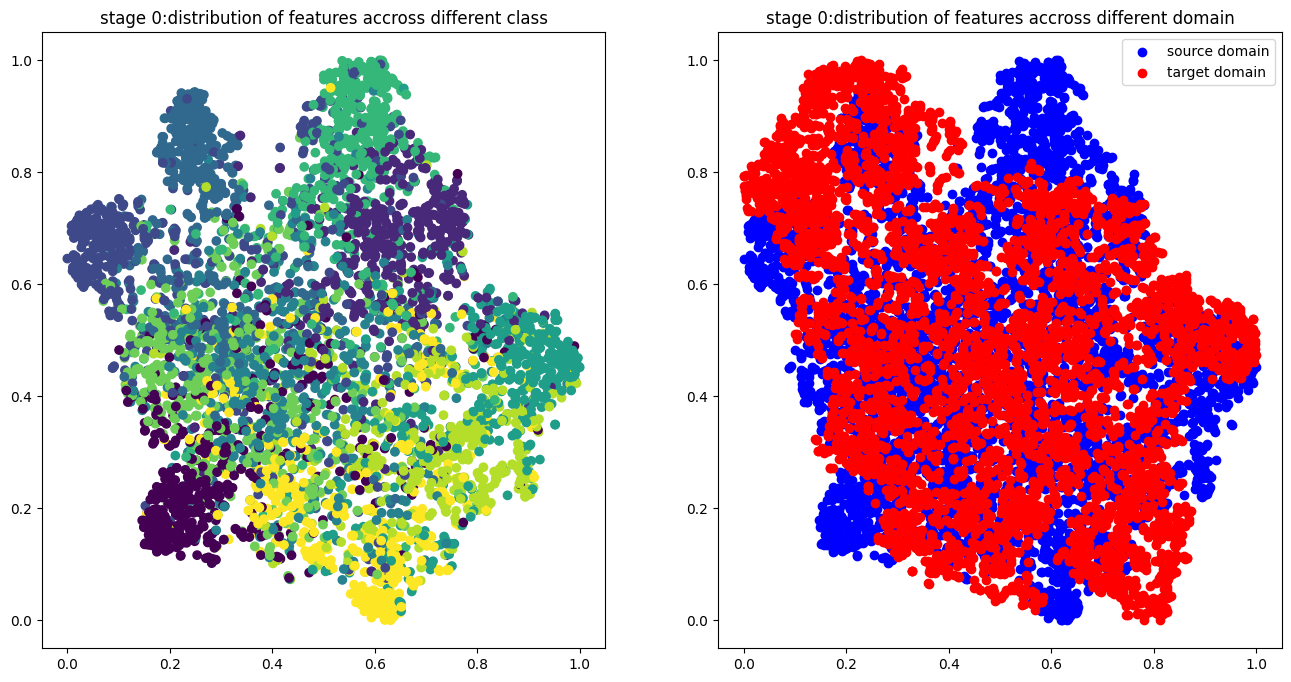

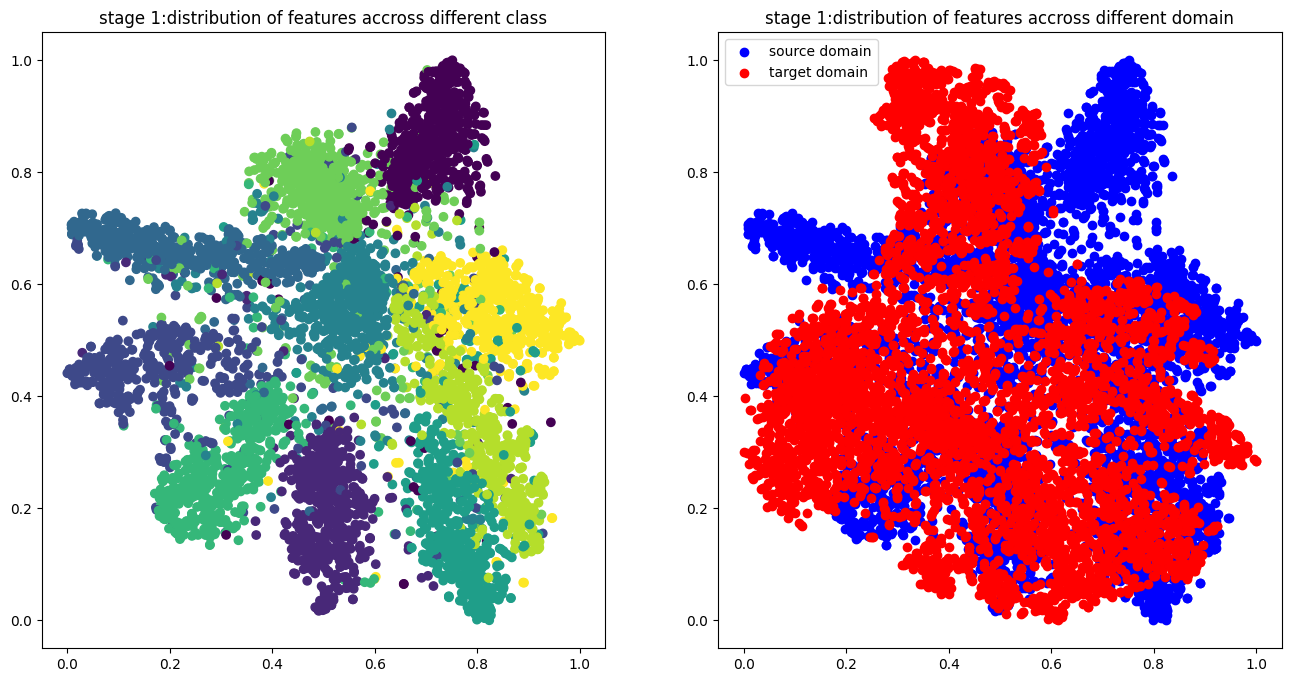

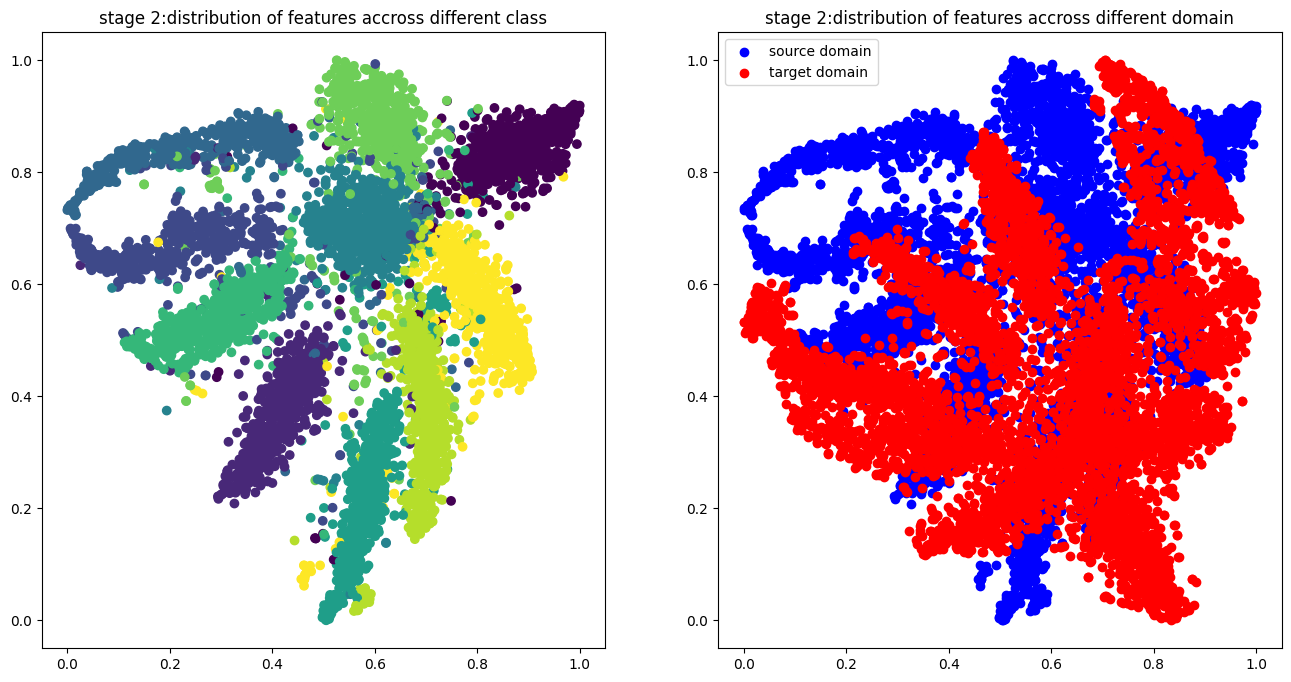

In [12]:
model_list = []
for epoch in ['_early', '_mid', '']:
    model = FeatureExtractor()
    model.load_state_dict(torch.load(f'extractor_model{epoch}.bin'))
    model_list.append(model)

visualization(get_features(model_list))

## Step1: Load checkpoint and evaluate to get extracted features

In [13]:
# Hints:
# Set features_extractor to eval mode
# Load saved checkpoints
# Start evaluation and collect features and labels

## Step2: Apply t-SNE and normalize

In [14]:
# process extracted features with t-SNE
# X_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(X)

# Normalization the processed features
# x_min, x_max = X_tsne.min(0), X_tsne.max(0)
# X_norm = (X_tsne - x_min) / (x_max - x_min)

## Step3: Visualization with matplotlib

In [15]:
# Data Visualization
# Use matplotlib to plot the distribution
# The shape of X_norm is (N,2)

# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Q&A

If there is any problem related to Domain Adaptation, please email to b08902047@ntu.edu.tw / mlta-2023-spring@googlegroups.com。

